In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import hyp2f1
from scipy.stats import norm

In [3]:
n = 200

repeat = 10000

# Zn1 has shape (repeat, n)
Zn1 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)  # une fois pour tout (invariant by eta and lam)
Zn2 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)

w1 = np.cumsum(Zn1, axis=1)
w2 = np.cumsum(Zn2, axis=1)

In [4]:
# Gaussian distributions, as reference
N_prime = norm.pdf
N = norm.cdf


def black_scholes_call(S, K, T, r, sigma):
    """

    :param S: Asset price
    :param K: Strike price
    :param T: Time to maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: call price
    """

    # standard black-scholes formula
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = S * N(d1) - N(d2) * K * np.exp(-r * T)
    return call


def vega_func(S, K, T, r, sigma):
    """

    :param S: Asset price
    :param K: Strike price
    :param T: Time to Maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: partial derivative w.r.t volatility
    """

    # calculating d1 from black scholes
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / sigma * np.sqrt(T)

    # see hull derivatives chapter on greeks for reference
    vega = S * N_prime(d1) * np.sqrt(T)
    return vega


def implied_volatility_call_newton(C, S, K, T, r, tol=0.0001, max_iterations=100):
    """

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    """

    # assigning initial volatility estimate for input in Newton_rap procedure
    sigma = 0.3
    eps = np.finfo(float).eps
    for i in range(max_iterations):

        # calculate difference between blackscholes price and market price with
        # iteratively updated volality estimate
        diff = black_scholes_call(S, K, T, r, sigma) - C

        # break if difference is less than specified tolerance level
        if abs(diff) < tol:
            break

        # use newton rapshon to update the estimate
        sigma = sigma - diff / (eps+vega_func(S, K, T, r, sigma))

    return sigma


def implied_volatility_call_bisection(C, S, K, T, r, tol=1e-7, max_iterations=500):
    """

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    """

    # assigning initial volatility estimate for input in Newton_rap procedure
    a = 0
    b = 1
    sigma = 0.5

    for i in range(max_iterations):

        # calculate difference between blackscholes price and market price with
        # iteratively updated volality estimate
        diff = black_scholes_call(S, K, T, r, sigma) - C

        # break if difference is less than specified tolerance level
        if abs(diff) < tol:
            break

        # use bisection method to update the estimate
        if diff < 0:
            if black_scholes_call(S, K, T, r, b) < C:
                a = b
                b = 2 * b
            a = sigma
            sigma = 0.5 * (a + b)
        if diff > 0:
            b = sigma
            sigma = 0.5 * (a + b)

    return sigma


def hallerbach_approximation(C, S, K, T, r):

    X = K * np.exp(-r * T)
    sigma = (1 / np.sqrt(T) * np.sqrt(2 * np.pi) / (2 * (S + X))) * (
        2 * C
        + X
        - S
        + np.sqrt(
            (2 * C + X - S) ** 2
            - 1.85 * (S + X) * (X - S) ** 2 / (np.pi * np.sqrt(X * S))
        )
    )
    # print((2 * C + X - S) ** 2 - 2 * (S + X) * (X - S) ** 2 / (S * np.pi))

    return sigma


In [5]:
# Exp Kernel-Cholesky for XT

def Sigma_exp(t, s, eta, lam):
    return (
        np.power(eta, 2)
        / (2 * lam)
        * np.exp(-lam * (s + t))
        * (np.exp(2 * lam * np.minimum(s, t)) - 1)
    )

def covariance_exp(T, eta, lam):
    '''Return the covariance Sigma for exponential kernel.
    '''
    times = np.linspace(0, T, n + 1)
    cov = np.zeros((n, n))
    for i in range(n):
        cov[i, :] = Sigma_exp(times[1+i], times[1:], eta=eta, lam=lam)
    return cov


In [6]:
# Frac Kernel-XT

def aux_integral_function(x,k,a):
    return x*(k+x**2)**a*((k+x**2)/k)**(-a)*hyp2f1(0.5, -a, 1.5, -x**2/k)

def Sigma_frac(t, s, H, c):
    a = H-0.5
    if t==s:
        return c**2 * 2*(t/2)**(2*a+1)/(2*a+1)
    else:
        k = 0.25*(s-t)**2
        xmin = - 0.5*(s+t)
        xmax = np.minimum(t,s) + xmin
        return c**2 * (aux_integral_function(xmax, k, a) - aux_integral_function(xmin, k, a))

def covariance_frac(T, H, c):
    times = np.linspace(0, T, n + 1)
    cov = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cov[i,j] = Sigma_frac(times[1+i], times[1+j], H=H, c=c)
    return cov


In [7]:

def sample_XT_Cholesky(lam, eta, Zns=Zn1, T=1.5):

    cov = covariance_exp(eta=eta, lam=lam, T=T)
    # print(np.sum((cov-cov.T)>0))
    # print(np.sum(cov>0))
    L = np.linalg.cholesky(covariance_exp(eta=eta, lam=lam, T=T))
    # t begins from t1=T/n but not t0=0
    sample = Zns @ L.T

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample, cov

def sample_XT_cumsum(lam, eta, Zns=Zn1, T=1.5):
    times = np.linspace(0, T, n + 1)
    sigma = eta * np.sqrt(np.exp(2*lam*times[:-1])*(np.exp(2*lam*T/n)-1)/(2*lam))
    sample = np.exp(-lam*times[1:]) * np.cumsum(Zns*sigma, axis=1)

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample
    

def sample_XT_frac(H, c, Zns=Zn1, T=1.5):

    cov = covariance_frac(T=T, H=H, c=c)
    L = np.linalg.cholesky(cov)
    
    sample =  Zns @ L.T

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_frac(T,T, H, c):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample, cov

In [8]:

def plot_sample(sample, ylabel="${X_T}$", title=f"Sample of XT with n={n}", save_pic=False):
    T=1.5
    times = np.linspace(0, T, n + 1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(times[1:], sample.T, "-")

    ax.set_xlabel("time t")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()
    if save_pic:
        plt.savefig(title)

In [9]:
def sample_B(rho=0.5, T=1.5):
    sample = rho*np.sqrt(T/n)*w1 + np.sqrt(1-rho**2)*np.sqrt(T/n)*w2
    
    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])
    demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"B_T: mean={mean:3.3f} var={var:3.3f} ({T:3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample

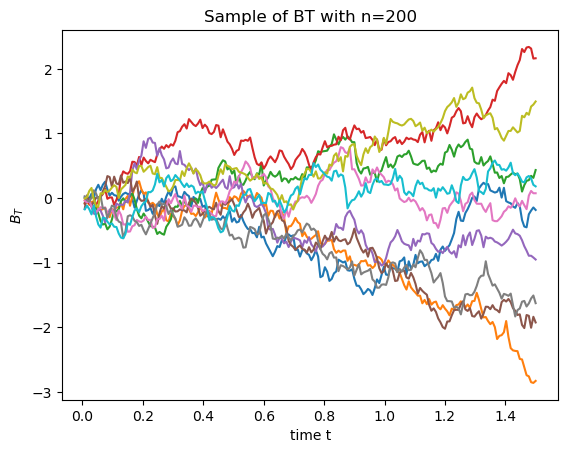

In [10]:
plot_sample(sample_B(rho=0)[:10], ylabel="${B_T}$", title=f"Sample of BT with n={n}")
print("")

In [11]:
def Sigma(X, vars, ksi=0.5, a0=1, a1=1):
    return ksi*(a0 + a1*X) / np.sqrt(a0**2 + a1**2*vars)

def Sigma_1(X, ksi=0.5, b=1, lam=1, eta=1, T=1):
    times = np.linspace(0, T, n + 1)[1:]
    return  ksi*np.exp(b*X)/ np.exp(b**2 * eta**2 * (1-np.exp(-2*lam*times))/(2*lam))     

def Sigma_ksit(X, T, vars, alpha0=0.2, alpha1=1, beta=1, a0=1, a1=1):
    tn = np.linspace(0, T, n + 1)[1:]
    return ((a0 + a1*X) / np.sqrt(a0**2 + a1**2*vars)) * (alpha0*np.exp(-beta**2*tn)+alpha1*(1-np.exp(-beta**2*tn)))

In [37]:
def sample_S_exp(rho=0.5, lam=1, eta=1, ksi=0.5, a0=1, T=[1.5], b=1, alpha0=0.2, alpha1=1, beta=1, pre=False, sig="poly"):
    sample=[]

    for T_unique in np.unique(T):

        X_sample, cov = sample_XT_Cholesky(lam=lam, eta=eta, T=T_unique)
        vars = np.diagonal(cov)

        if sig=="poly":
            sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars, ksi=ksi, a0=a0)))
        elif sig=="exp":
            sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma_1(X_sample, ksi=ksi, b=b, lam=lam, eta=eta, T=T_unique)))
        elif sig=="ksit":
            sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma_ksit(X_sample, T=T_unique, vars=vars, alpha0=alpha0, alpha1=alpha1, beta=beta, a0=a0)))

        B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho,T=T_unique)))
        sum1 = np.cumsum((0.5*(sigma[:, :-1]+sigma[:, 1:]))**2*T_unique/n, axis=1)
        sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
        sample_S = np.hstack((np.ones(repeat).reshape(-1,1), np.exp(-0.5*sum1+sum2)))
        sample.append(sample_S)
        
    if pre:    
        mean = np.mean(sample[0][:, -1])
        var = np.var(sample[0][:, -1])
        demi_width_IC = np.sqrt(var/repeat) * 1.96
        print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
        print("IC(95%%) = [%1.3f, %1.3f] \n" \
        %(mean-demi_width_IC, mean + demi_width_IC))
            
    return np.array(sample)

def sample_S_frac(rho=0.5, H=0.5, c=1, ksi=0.5, a0=1, T=[1.5], alpha0=0.2, alpha1=1, beta=1, pre=False, sig="poly"):
    sample=[]
    for T_unique in np.unique(T):
        X_sample, cov = sample_XT_frac(H=H, c=c, T=T_unique)
        vars = np.diagonal(cov)

        if sig=="poly":
            sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars, ksi=ksi, a0=a0)))
        elif sig=="ksit":
            sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma_ksit(X_sample, T=T_unique, vars=vars, alpha0=alpha0, alpha1=alpha1, beta=beta, a0=a0)))

        B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho,T=T_unique)))
        sum1 = np.cumsum((0.5*(sigma[:, :-1]+sigma[:, 1:]))**2*T_unique/n, axis=1)
        sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
        sample_S = np.hstack((np.ones(repeat).reshape(-1,1), np.exp(-0.5*sum1+sum2)))
        
        sample.append(sample_S)
        
        if pre:    
            mean = np.mean(sample[0][:, -1])
            var = np.var(sample[0][:, -1])
            demi_width_IC = np.sqrt(var/repeat) * 1.96
            print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
            print("IC(95%%) = [%1.3f, %1.3f] \n" \
            %(mean-demi_width_IC, mean + demi_width_IC))
            
    return np.array(sample)

def sample_S_iso(rho=0.5, v=1, epsilon=1, H=0.5, ksi=0.5, a0=1, T=[1.5], alpha0=0.2, alpha1=1, beta=1, pre=False, sig="poly"):
    sample=[]
    eta = v*epsilon**(H-0.5)
    lam = -1/epsilon*(H-0.5)
    # print("lam=", lam, "\n eta=", eta)

    for T_unique in np.unique(T):

        X_sample, cov = sample_XT_Cholesky(lam=lam, eta=eta, T=T_unique)
        vars = np.diagonal(cov)

        if sig=="poly":
            sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars, ksi=ksi, a0=a0)))
    
        elif sig=="ksit":
            sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma_ksit(X_sample, T=T_unique, vars=vars, alpha0=alpha0, alpha1=alpha1, beta=beta, a0=a0)))

        B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho,T=T_unique)))
        sum1 = np.cumsum((0.5*(sigma[:, :-1]+sigma[:, 1:]))**2*T_unique/n, axis=1)
        sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
        sample_S = np.hstack((np.ones(repeat).reshape(-1,1), np.exp(-0.5*sum1+sum2)))
        sample.append(sample_S)
        
    if pre:    
        mean = np.mean(sample[0][:, -1])
        var = np.var(sample[0][:, -1])
        demi_width_IC = np.sqrt(var/repeat) * 1.96
        print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
        print("IC(95%%) = [%1.3f, %1.3f] \n" \
        %(mean-demi_width_IC, mean + demi_width_IC))
            
    return np.array(sample)


S_T: mean=0.996 var=0.186
IC(95%) = [0.987, 1.004] 

(1, 10000, 201)


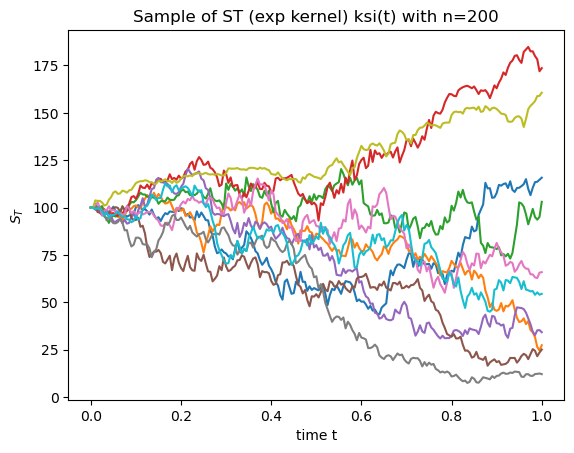

In [38]:
T = 1
times = np.linspace(0, T, n + 1)
sample = sample_S_exp(rho=-0.8, T=[1], pre=True, sig="ksit")
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(times, 100*sample[0][:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (exp kernel) ksi(t) with n={n}")
plt.show()


S_T: mean=0.995 var=0.176
IC(95%) = [0.987, 1.004] 

(1, 10000, 201)


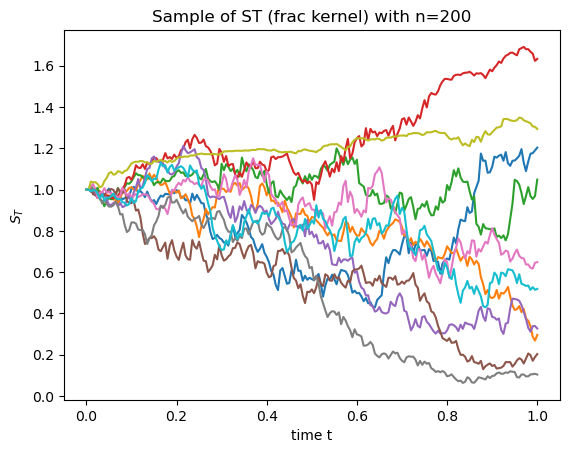

In [39]:
T = 1
times = np.linspace(0, T, n + 1)
sample = sample_S_frac(rho=-0.8, T=[T], pre=True, sig="ksit")
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(times, sample[0][:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (frac kernel) with n={n}")
plt.show()


In [52]:
%%time
# Here we calibrate using scipy.optimize for plural slices
from scipy.optimize import least_squares


def loss_1(x, K, y, S0, T, kernel: str):
    ''' loss function 
        x: input-x0=K, x1=S0, x2=T
        u: parameters-rho, H, c, ksi, a0
        y: the real call price
        kernel: type of kernel-'frac' or 'exp'
    '''
    if kernel=='frac':
        ST = sample_S_frac(T=T, rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4])[:,:,-1]
    
    if kernel=='exp':
        ST = sample_S_exp(T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], a0=x[4])[:,:,-1]
        
    if kernel=="iso":
        ST = sample_S_iso(T=T, rho=x[0], v=x[1], epsilon=x[2], H=x[3], ksi=x[4], a0=x[5])[:,:,-1]
        
    if kernel=="exp1":
        ST = sample_S_exp(T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], b=x[4], sig="exp")[:,:,-1]
    
    if kernel=='ksit':
        ST = sample_S_exp(T=T, rho=x[0], lam=x[1], eta=x[2], alpha0=x[3], alpha1=x[4], beta=x[5], a0=x[6], sig="ksit")[:,:,-1]
        
    if kernel=='ksit_frac':
        ST = sample_S_frac(T=T, rho=x[0], H=x[1], c=x[2], alpha0=x[3], alpha1=x[4], beta=x[5], a0=x[6], sig="ksit")[:,:,-1]
        
    if kernel=='ksit_iso':
        ST = sample_S_iso(T=T, rho=x[0], v=x[1], epsilon=x[2], H=x[3], alpha0=x[4], alpha1=x[5], beta=x[6], a0=x[7], sig="ksit")[:,:,-1]
    
    T_unique = np.unique(Ts)
    return np.array([np.mean(np.maximum(S0[i]*ST[T_unique.tolist().index(T[i])]-K[i], 0))-y[i] for i in range(len(y))])

def loss_2(x, K, y, S0, T, kernel: str):
    ''' loss function 
        x: input-x0=K, x1=S0, x2=T
        u: parameters-rho, H, c, ksi, a0
        y: the real call price
        kernel: type of kernel-'frac' or 'exp'
    '''
    if kernel=='frac':
        ST = sample_S_frac(T=T, rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4])[:,:,-1]
    
    if kernel=='exp':
        ST = sample_S_exp(T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], a0=x[4])[:,:,-1]
        
    if kernel=="iso":
        ST = sample_S_exp_iso(T=T, rho=x[0], v=x[1], epsilon=x[2], H=x[3], ksi=x[4], a0=x[5])[:,:,-1]
        
    if kernel=="exp1":
        ST = sample_S_exp(T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], b=x[4], sig="exp")[:,:,-1]
    
    T_unique = np.unique(Ts)
    return np.array([np.mean(np.maximum(S0[i]*ST[T_unique.tolist().index(T[i])]-K[i], 0))-y[i] for i in range(len(y))]) * np.exp(-0.5*T)

def loss_3(x, K, y, S0, T, kernel: str):
    ''' loss function 
        x: input-x0=K, x1=S0, x2=T
        u: parameters-rho, H, c, ksi, a0
        y: the real call price
        kernel: type of kernel-'frac' or 'exp'
    '''
    if kernel=='frac':
        ST = sample_S_frac(T=T, rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4])[:,:,-1]
    
    if kernel=='exp':
        ST = sample_S_exp( T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], a0=x[4])[:,:,-1]
    
    if kernel=="iso":
        ST = sample_S_iso(T=T, rho=x[0], v=x[1], epsilon=x[2], H=x[3], ksi=x[4], a0=x[5])[:,:,-1]
    
    if kernel=="exp1":
        ST = sample_S_exp(T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], b=x[4], sig="exp")[:,:,-1]
        
    if kernel=='ksit':
        ST = sample_S_exp(T=T, rho=x[0], lam=x[1], eta=x[2], alpha0=x[3], alpha1=x[4], beta=x[5], a0=x[6], sig="ksit")[:,:,-1]
    
    if kernel=='ksit_frac':
        ST = sample_S_frac(T=T, rho=x[0], H=x[1], c=x[2], alpha0=x[3], alpha1=x[4], beta=x[5], a0=x[6], sig="ksit")[:,:,-1]
    
    if kernel=='ksit_iso':
        ST = sample_S_iso(T=T, rho=x[0], v=x[1], epsilon=x[2], H=x[3], alpha0=x[4], alpha1=x[5], beta=x[6], a0=x[7], sig="ksit")[:,:,-1]
    
    T_unique = np.unique(Ts)
    return np.array([(np.mean(np.maximum(S0[i]*ST[T_unique.tolist().index(T[i])]-K[i], 0))-y[i])/np.sqrt(vega[i]) for i in range(len(y))])

def calibration(Ks, y, S0, T, kernel="frac", loss=loss_1):
    if kernel == "frac":
        x0 = np.array([-0.7, 0.25, 0.5, 0.2, 0.5])
        bounds=([-1, 0, 0, 0, 0], [-0.5, 0.5, 2, 2, 2])
    elif kernel=="exp":
        x0=np.array([-0.75, 1, 1, 0.2, 0.5])
        bounds=([-1, 0, 0, 0, 0], [-0.5, 5, 5, 3, 3])
    elif kernel=="iso":
        x0=np.array([-0.75, 1, 1/52, 0.25, 0.2, 0.5])
        bounds=([-1, 0, 0, 0, 0, 0], [-0.5, 1.5, 1, 1, 3, 3])
    elif kernel=="exp1":
        x0=np.array([-0.75, 1, 1, 0.2, 1])
        bounds=([-1, 0, 0, 0, -1], [-0.5, 5, 5, 3, 3])
    elif kernel=="ksit":
        x0=np.array([-0.75, 1, 1, 0.1, 0.4, 2, 0.5])
        bounds=([-1, 0, 0, 0, 0, 0, 0], [-0.5, 5, 5, 2, 5, 10, 3])
    elif kernel=="ksit_frac":
        x0=np.array([-0.75, 0.25, 0.5, 0.1, 0.4, 2, 0.5])
        bounds=([-1, 0, 0, 0, 0, 0, 0], [-0.5, 0.5, 2, 2, 5, 10, 3])    
    elif kernel=="ksit_iso":
        x0=np.array([-0.75, 1, 1/52, 0.25, 0.2, 0.2, 2, 0.5])
        bounds=([-1, 0, 0, 0, 0, 0, 0, 0], [-0.5, 1.5, 1, 1, 2, 5, 10, 3])
    
    return least_squares(loss, x0, bounds=bounds, args=(Ks, y, S0, T, kernel), ftol=1e-9, xtol=1e-9, gtol=1e-9, verbose=1)

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 13.8 µs


In [41]:
def test_implied_vol(S0, T, Ks, call_models, vol_markets, vol_ask, vol_bid, loss_type="1", model="frac"):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    vol_models = np.array([implied_volatility_call_bisection(C=call_models[i], S=S0[i], K=Ks[i], T=T[i], r=0) for i in range(len(Ks))])
    # vol_markets = np.array([implied_volatility_call_bisection(C=call_markets[i], S=S0, K=Ks[i], T=T, r=0) for i in range(len(Ks))])

    ax.plot(np.log(Ks/S0), vol_models, label="model")
    ax.scatter(np.log(Ks/S0), vol_markets, label="market", s=0.4, c="red")
    ax.scatter(np.log(Ks/S0), vol_ask, label="ask", s=0.4, c="green")
    ax.scatter(np.log(Ks/S0), vol_bid, label="bid", s=0.4, c="black")
    
    ax.set_xlabel('K/S')
    ax.set_ylabel('$Implied volatility$')
    ax.set_title(f"loss type: loss{loss_type}, model: {model}, T={int(T[0]*365)}")

    plt.legend(loc='best')

    plt.show()
    
    loss_MSE = np.mean((vol_markets-vol_models)**2)
    print("Mean squared error:{:.3g}".format(loss_MSE))
  

In [42]:
# Ks=np.arange(80,122,2)
# y = np.array([call_frac(S0=100, K=Ks[i], T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5) for i in range(len(Ks))])

# res = calibration(Ks, y, S0=100, T=1.5, loss=loss_1)
# print(res)

# params = res.x

# call_markets = np.array([call_frac(S0=100, K=Ks[i], T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5) for i in range(len(Ks))]) 
# call_models= np.array([call_frac(S0=100, K=Ks[i], T=1.5, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4]) for i in range(len(Ks))])  
# test_implied_vol(S0=100, T=1.5, Ks=Ks, call_models=call_models, call_markets=call_markets) 

### Calibration with 1 unique maturity

In [43]:
# Read data
data = pd.read_csv('../data/UnderlyingOptionsEODCalcs_2022-09-02.csv')

# Remove all data not traded in reality
data = data[data["trade_volume"]>0]

# Rename some columns according to convention
data.rename(columns={'strike': 'K','implied_underlying_price_1545':'S0', "implied_volatility_1545":"implied_volatility", "vega_1545":"vega"}, inplace=True)

# We only process data for calls here
data = data[data['option_type']=='C']
data = data[data["root"]=="SPX"]
# Calculate the time difference based on the quote date and expiration and convert to days
data['T'] = (data["expiration"].map(lambda x: pd.Timestamp(x)) - data["quote_date"].map(lambda x: pd.Timestamp(x))).map(lambda x: int(x.days)/365.0)

# We use the average of bid and ask for the actual market price
data['call_markets'] = 0.5 * (data['bid_1545']+data['ask_1545'])

print("All maturities: \n", np.unique(np.sort(data["T"].to_numpy())))

T = 14/365
print("Chosen maturity:", T*365)
data = data[data['T']==T]
S0 = data['S0'].to_numpy()[0] 
data = data[data['S0']==S0]
data = data[np.abs((data["K"]-S0)/S0)<0.05]

Ks = data['K'].to_numpy()
S0s = [S0]*len(Ks)
Ts = [T]*len(Ks)
call_markets = data['call_markets'].to_numpy()
vega = data["vega"].to_numpy()
vol_markets = data["implied_volatility"].to_numpy()
print("Number of points:", len(Ks) )
call_ask = data['ask_1545'].to_numpy()
call_bid = data['bid_1545'].to_numpy()

vol_markets = [implied_volatility_call_bisection(C=call_markets[i], S=S0, K=Ks[i], T=T, r=0) for i in range(len(Ks))]
vol_ask = [implied_volatility_call_bisection(C=call_ask[i], S=S0, K=Ks[i], T=T, r=0) for i in range(len(Ks))]
vol_bid = [implied_volatility_call_bisection(C=call_bid[i], S=S0, K=Ks[i], T=T, r=0) for i in range(len(Ks))]
vega = np.array([vega_func(S0, Ks[i], T, r=0, sigma = vol_markets[i]) + 1e-8 for i in range(len(Ks))])


All maturities: 
 [0.03835616 0.13424658 0.2109589  0.28767123 0.38356164 0.46027397
 0.5369863  0.63287671 0.70958904 0.78630137 0.88219178 0.95890411
 1.03561644 1.28493151 1.80273973 2.30136986 4.29589041 5.29315068]
Chosen maturity: 14.0
Number of points: 61


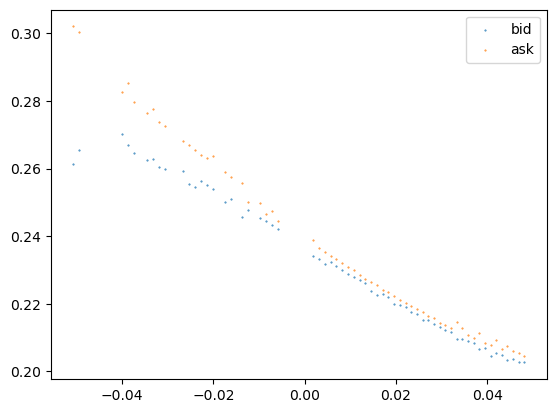

In [44]:
plt.scatter(np.log(Ks/S0), vol_bid, label="bid", s=0.2)
plt.scatter(np.log(Ks/S0), vol_ask, label="ask", s=0.2)
plt.legend()

`ftol` termination condition is satisfied.
Function evaluations 39, initial cost 1.4042e+01, final cost 2.6022e-03, first-order optimality 1.29e-05.
[-0.68663135  0.35227735  0.74431668  0.25477985  0.3821378 ]


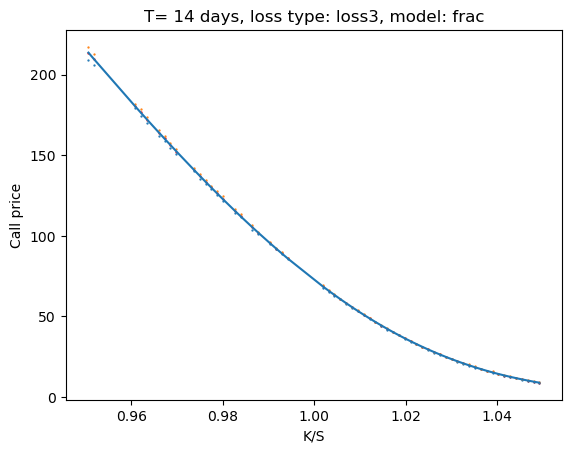

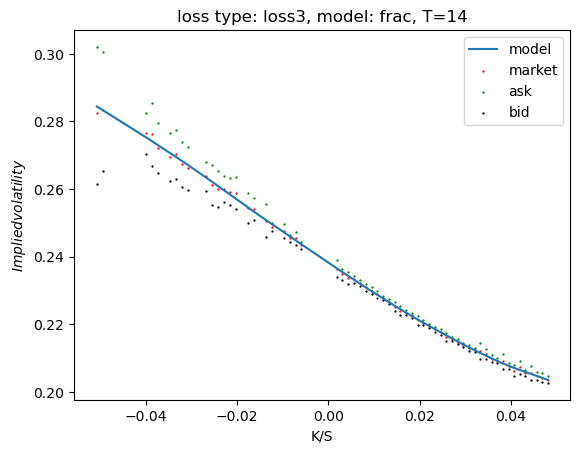

Mean squared error:4.32e-07


In [29]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3)
params = res.x
print(params)

ST = S0*sample_S_frac(T=Ts, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4])[0,:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.scatter(Ks/S0, data["bid_1545"].to_numpy(), s=0.4)
ax.scatter(Ks/S0, data["ask_1545"].to_numpy(), s=0.4)
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {int(T*365)} days, loss type: loss3, model: frac")
plt.show()


test_implied_vol(S0=S0s, T=Ts, Ks=Ks, call_models=call_models, vol_markets=vol_markets, vol_ask = vol_ask, vol_bid = vol_bid, loss_type=3)    

In [104]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="exp")
params = res.x

`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 9.4408e+00, final cost 3.0729e-03, first-order optimality 3.54e-07.


rho=-0.596, lam=5.000000, eta=1.362, ksi=0.242, a0=0.457 
[-0.59576143  5.          1.36200319  0.24176598  0.4567662 ]


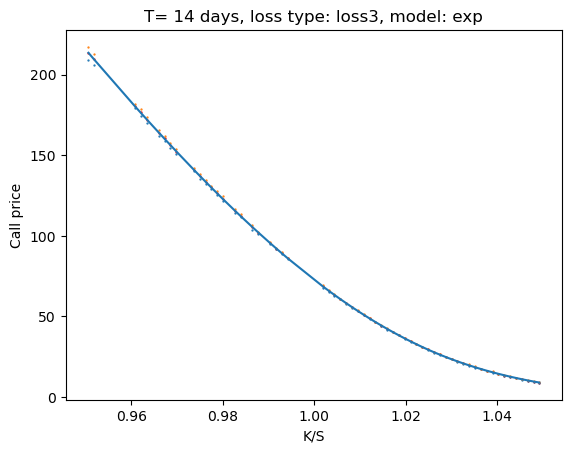

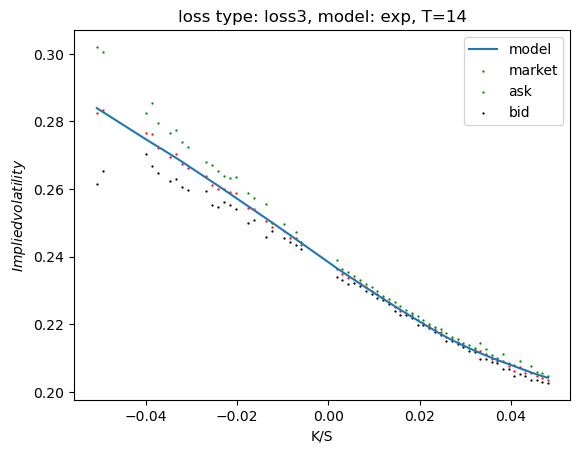

Mean squared error:5.14e-07


In [105]:
print(f"rho={params[0]:.3f}, lam={params[1]:.6f}, eta={params[2]:.3f}, ksi={params[3]:.3f}, a0={params[4]:.3f} ")
print(params)
ST = S0*sample_S_exp(T=Ts, rho=params[0], lam=params[1], eta=params[2], ksi=params[3], a0=params[4])[0,:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.scatter(Ks/S0, data["bid_1545"].to_numpy(), s=0.4)
ax.scatter(Ks/S0, data["ask_1545"].to_numpy(), s=0.4)
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {int(T*365)} days, loss type: loss3, model: exp")
plt.show()


test_implied_vol(S0=S0s, T=Ts, Ks=Ks, call_models=call_models, vol_markets=vol_markets, vol_ask = vol_ask, vol_bid = vol_bid, model="exp", loss_type=3)    

In [47]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="iso")
params = res.x 

`ftol` termination condition is satisfied.
Function evaluations 45, initial cost 1.9675e+01, final cost 3.0818e-03, first-order optimality 1.45e-04.


rho=-0.626, lam=24.012, eta=3.026, ksi=0.256, a0=0.6032921760802081 
[-0.62606321  0.99817387  0.01003636  0.25900672  0.25613203  0.60329218]


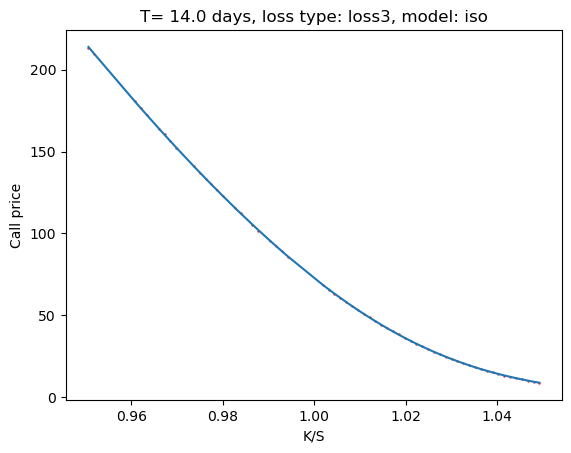

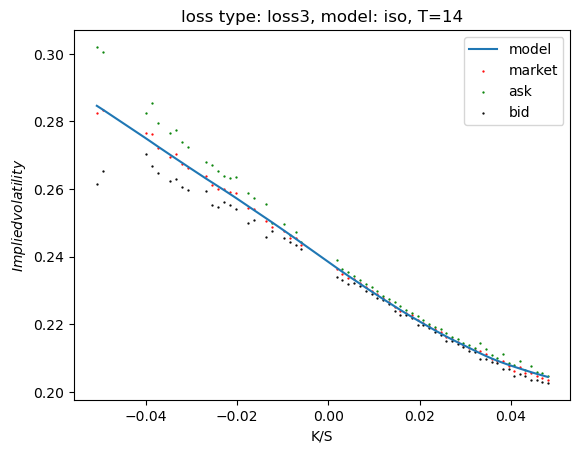

Mean squared error:5.27e-07


In [49]:
eta = params[1]*params[2]**(params[3]-0.5)
lam = -(params[3]-0.5)/params[2]
print(f"rho={params[0]:.3f}, lam={lam:.3f}, eta={eta:.3f}, ksi={params[4]:.3f}, a0={params[5]} ")
print(params)
ST = S0*sample_S_iso(T=Ts, rho=params[0], v=params[1], epsilon=params[2], H=params[3], ksi=params[4], a0=params[5])[0,:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {T*365} days, loss type: loss3, model: iso")
plt.show()


test_implied_vol(S0=S0s, T=Ts, Ks=Ks, call_models=call_models, vol_markets=vol_markets, vol_ask = vol_ask, vol_bid = vol_bid, model="iso", loss_type=3)   

In [76]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="exp1")
params = res.x

`ftol` termination condition is satisfied.
Function evaluations 24, initial cost 8.3351e+00, final cost 2.9622e-03, first-order optimality 1.10e-05.


rho=-0.631, lam=4.999954, eta=1.694, ksi=0.245, b=1.592 
[-0.6312005   4.99995404  1.69403602  0.24544248  1.59248889]


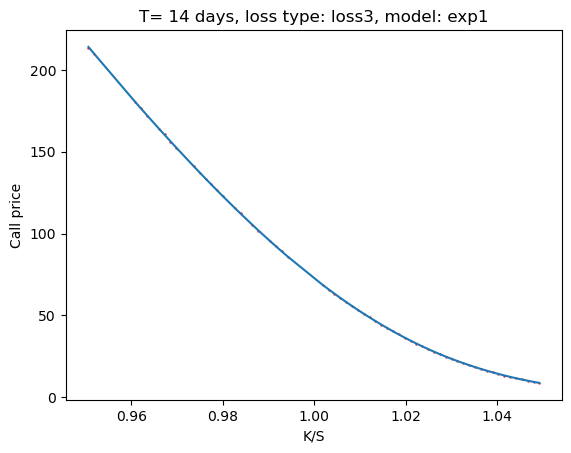

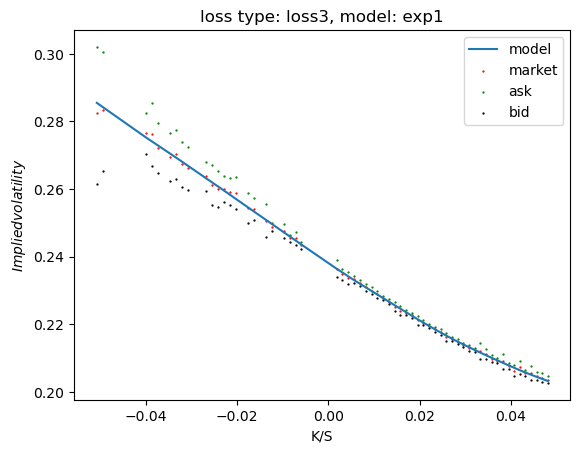

Mean squared error:5.34e-07


In [77]:
print(f"rho={params[0]:.3f}, lam={params[1]:.6f}, eta={params[2]:.3f}, ksi={params[3]:.3f}, b={params[4]:.3f} ")
print(params)
ST = S0*sample_S_exp(T=Ts, rho=params[0], lam=params[1], eta=params[2], ksi=params[3], b=params[4], sig="exp")[0,:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {int(T*365)} days, loss type: loss3, model: exp1")
plt.show()


test_implied_vol(S0=S0s, T=Ts, Ks=Ks, call_models=call_models, vol_markets=vol_markets, vol_ask = vol_ask, vol_bid = vol_bid, model="exp1", loss_type=3)    

In [80]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="ksit")
params = res.x

`ftol` termination condition is satisfied.
Function evaluations 100, initial cost 7.3209e+00, final cost 4.0561e-03, first-order optimality 9.09e-05.


rho=-0.628, lam=4.998341, eta=1.245, alpha0=0.245, alpha1=0.930, beta=0.920, a0=0.313
[-0.62842213  4.99834147  1.24450691  0.24548054  0.9301603   0.92003641
  0.31280499]


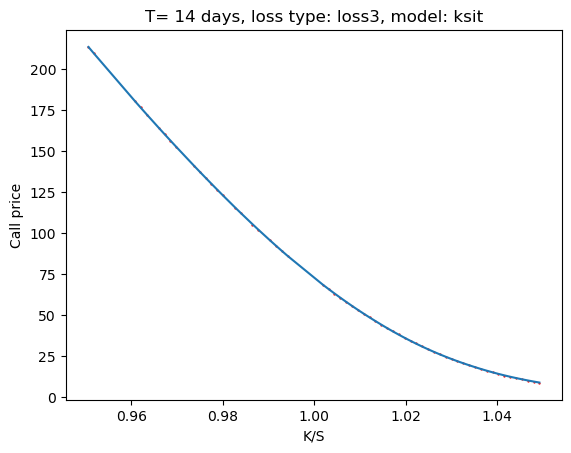

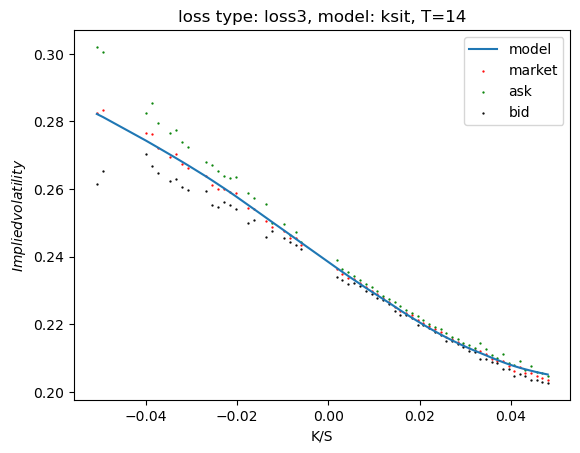

Mean squared error:7.28e-07


In [81]:
print(f"rho={params[0]:.3f}, lam={params[1]:.6f}, eta={params[2]:.3f}, alpha0={params[3]:.3f}, alpha1={params[4]:.3f}, beta={params[5]:.3f}, a0={params[6]:.3f}")
print(params)
ST = S0*sample_S_exp(T=Ts, rho=params[0], lam=params[1], eta=params[2], alpha0=params[3], alpha1=params[4], beta=params[5], a0=params[6], sig="ksit")[0,:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {int(T*365)} days, loss type: loss3, model: ksit")
plt.show()


test_implied_vol(S0=S0s, T=Ts, Ks=Ks, call_models=call_models, vol_markets=vol_markets, vol_ask = vol_ask, vol_bid = vol_bid, model="ksit", loss_type=3)    

`ftol` termination condition is satisfied.
Function evaluations 44, initial cost 7.7298e+01, final cost 2.5728e-03, first-order optimality 2.84e-05.
[-0.69490232  0.33052476  0.79242916  0.20702923  0.67537716  2.3669152
  0.48865822]


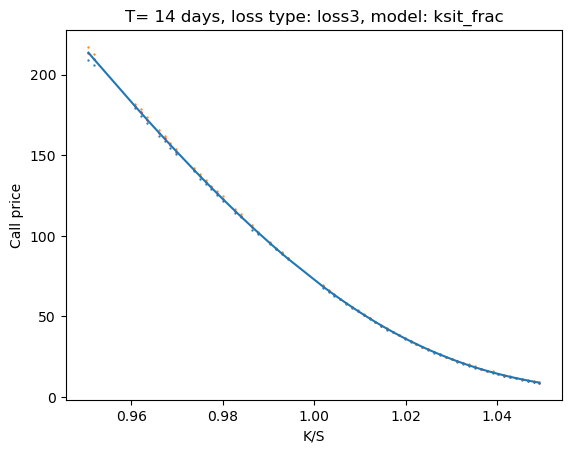

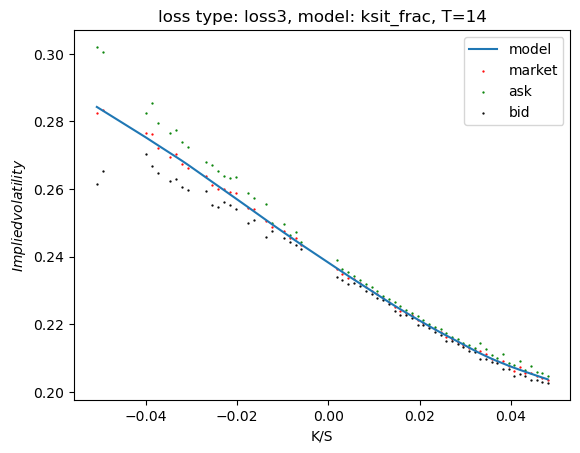

Mean squared error:4.27e-07


In [30]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="ksit_frac")
params = res.x
print(params)

ST = S0*sample_S_frac(T=Ts, rho=params[0], H=params[1], c=params[2], alpha0=params[3], alpha1=params[4], beta=params[5], a0=params[6], sig="ksit")[0,:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.scatter(Ks/S0, data["bid_1545"].to_numpy(), s=0.4)
ax.scatter(Ks/S0, data["ask_1545"].to_numpy(), s=0.4)
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {int(T*365)} days, loss type: loss3, model: ksit_frac")
plt.show()


test_implied_vol(S0=S0s, T=Ts, Ks=Ks, call_models=call_models, vol_markets=vol_markets, vol_ask = vol_ask, vol_bid = vol_bid, loss_type=3, model="ksit_frac")    

In [53]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="ksit_iso")
params = res.x 

`ftol` termination condition is satisfied.
Function evaluations 652, initial cost 1.9675e+01, final cost 2.6776e-03, first-order optimality 1.04e-04.


rho=-0.628, lam=0.897, eta=1.413, ksi=0.324, a0=0.03161384983255036 
[-0.62775219  1.04204254  0.23379645  0.29024622  0.32444123  0.03161385
  3.93687894  0.32846165]


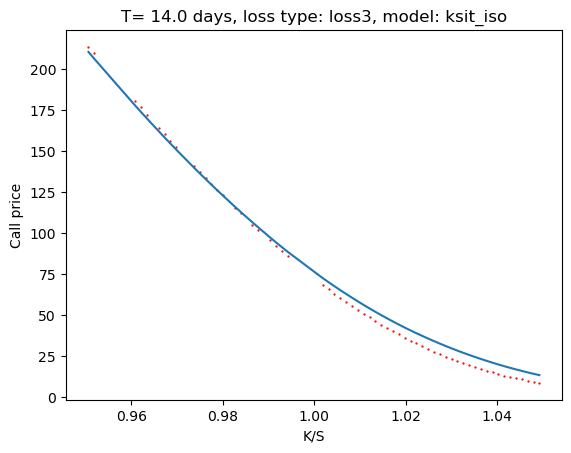

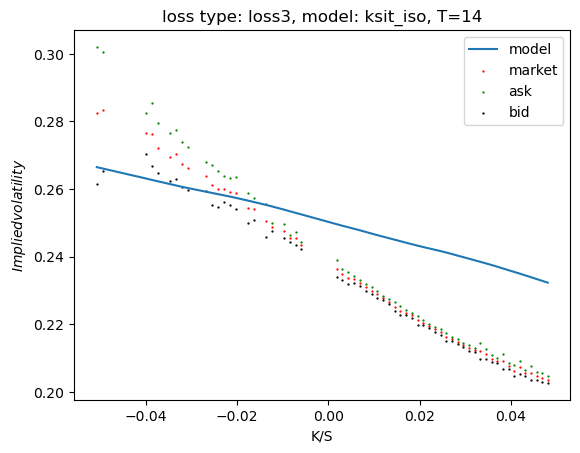

Mean squared error:0.000373


In [54]:
eta = params[1]*params[2]**(params[3]-0.5)
lam = -(params[3]-0.5)/params[2]
print(f"rho={params[0]:.3f}, lam={lam:.3f}, eta={eta:.3f}, ksi={params[4]:.3f}, a0={params[5]} ")
print(params)
ST = S0*sample_S_iso(T=Ts, rho=params[0], v=params[1], epsilon=params[2], H=params[3], alpha0=params[4], alpha1=params[5], beta=params[6], sig="ksit")[0,:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {T*365} days, loss type: loss3, model: ksit_iso")
plt.show()


test_implied_vol(S0=S0s, T=Ts, Ks=Ks, call_models=call_models, vol_markets=vol_markets, vol_ask = vol_ask, vol_bid = vol_bid, model="ksit_iso", loss_type=3)   

### Calibration over 4-6 dates

In [92]:
# Read data
data = pd.read_csv('../data/UnderlyingOptionsEODCalcs_2022-09-02.csv')

# Remove all data not traded in reality
data = data[data["trade_volume"]>0]

# Rename some columns according to convention
data.rename(columns={'strike': 'K','implied_underlying_price_1545':'S0', "implied_volatility_1545":"implied_volatility", "vega_1545":"vega"}, inplace=True)

# We only process data for calls here
data = data[data['option_type']=='C']
data = data[data["root"]=="SPX"]
# Calculate the time difference based on the quote date and expiration and convert to days
data['T'] = (data["expiration"].map(lambda x: pd.Timestamp(x)) - data["quote_date"].map(lambda x: pd.Timestamp(x))).map(lambda x: int(x.days))

# We use the average of bid and ask for the actual market price
data['call_markets'] = 0.5 * (data['bid_1545']+data['ask_1545'])

print(data["T"].value_counts().sort_index())

filter_T= [105, 140, 168]
filter_KS = {filter_T[0]:0.2, filter_T[1]:0.25, filter_T[2]:0.3}
data = data[(data['T'].isin(filter_T))]

data["KS"] = data["T"].map(lambda x: filter_KS[x])
data = data[np.abs((data["K"]-data["S0"])/data["S0"])<data["KS"]]

S0s = data['S0'].to_numpy()
Ks = data['K'].to_numpy()
Ts = data['T'].to_numpy()/365 # If we don't divide T by 365, there will be overflow for calculations of covariance matrix

call_markets = data['call_markets'].to_numpy()
vega = data["vega"].to_numpy()
vol_markets = data["implied_volatility"].to_numpy()

assert len(S0s)==len(Ks)

print("All maturities:")
print(data["T"].value_counts().sort_index())
print("Total points:", len(Ks))

call_ask = data['ask_1545'].to_numpy()
call_bid = data['bid_1545'].to_numpy()

vol_markets = [implied_volatility_call_bisection(C=call_markets[i], S=S0s[i], K=Ks[i], T=Ts[i], r=0) for i in range(len(Ks))]
vol_ask = [implied_volatility_call_bisection(C=call_ask[i], S=S0s[i], K=Ks[i], T=Ts[i], r=0) for i in range(len(Ks))]
vol_bid = [implied_volatility_call_bisection(C=call_bid[i], S=S0s[i], K=Ks[i], T=Ts[i], r=0) for i in range(len(Ks))]
vega = np.array([vega_func(S0s[i], Ks[i], Ts[i], r=0, sigma = vol_markets[i]) + 1e-8 for i in range(len(Ks))])


14      134
49      173
77       69
105      81
140      57
168      48
196      41
231      14
259      17
287      31
322       3
350      10
378      19
469      29
658       7
840       2
1568      2
1932      2
Name: T, dtype: int64
All maturities:
105    66
140    47
168    41
Name: T, dtype: int64
Total points: 154


In [97]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_2, kernel="exp")
params1 = res.x

`ftol` termination condition is satisfied.
Function evaluations 29, initial cost 1.5362e+05, final cost 1.7420e+02, first-order optimality 1.08e-01.


rho=-0.865, lam=2.970700, eta=3.200, ksi=0.306, a0=0.23934276124214254 
[-0.86461707  2.97070013  3.20036664  0.30565272  0.23934276]
(154,)


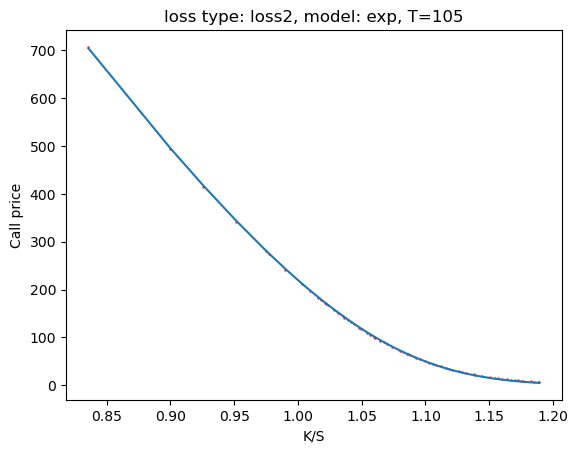

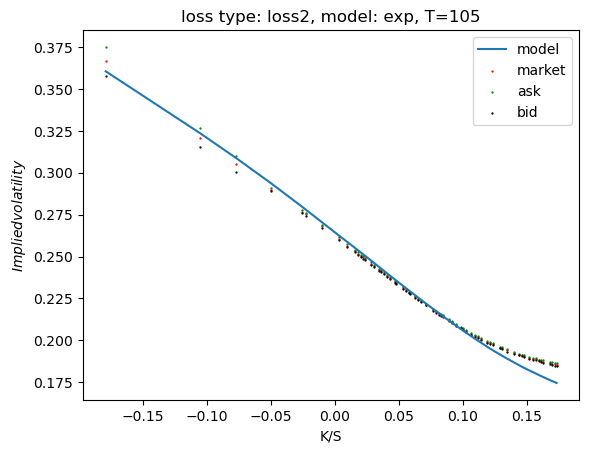

Mean squared error:1.97e-05


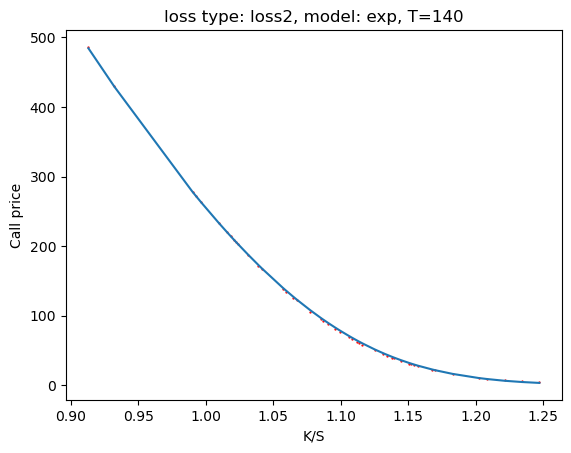

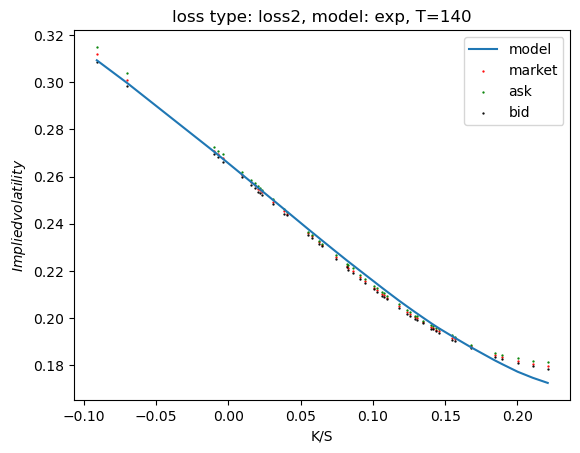

Mean squared error:5.33e-06


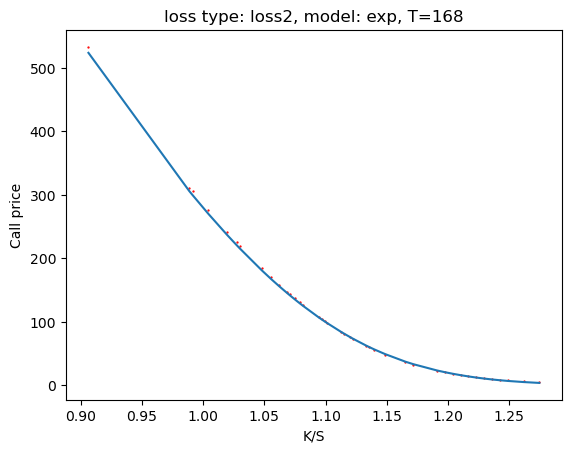

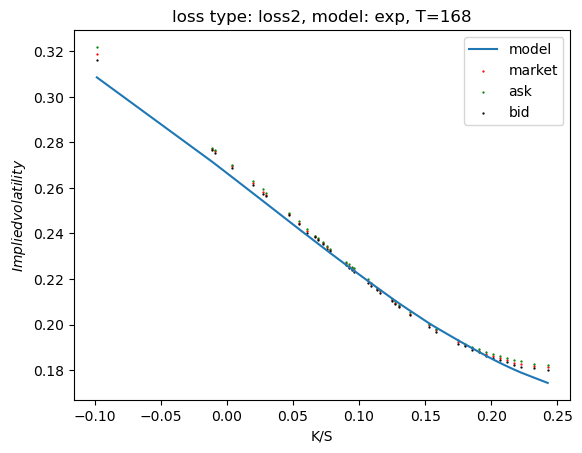

Mean squared error:9.79e-06


In [98]:
print(f"rho={params1[0]:.3f}, lam={params1[1]:.6f}, eta={params1[2]:.3f}, ksi={params1[3]:.3f}, a0={params1[4]} ")
print(params1)
ST = sample_S_exp(T=Ts, rho=params1[0], lam=params1[1], eta=params1[2], ksi=params1[3], a0=params1[4])[:,:,-1]
T_unique = np.unique(Ts)

call_models = np.array([np.mean(np.maximum(S0s[i]*ST[T_unique.tolist().index(Ts[i])]-Ks[i], 0))  for i in range(len(Ks))])
print(call_models.shape)


for T_view in filter_T:
    T_view = T_view/365
    fig = plt.figure()
    ax = fig.add_subplot(111) 
    ax.scatter(Ks[np.array(Ts)==T_view]/S0s[np.array(Ts)==T_view], np.array(call_markets)[np.array(Ts)==T_view], s=0.4, c="red")
    ax.plot(Ks[np.array(Ts)==T_view]/S0s[np.array(Ts)==T_view], np.array(call_models)[np.array(Ts)==T_view], "-")


    ax.set_xlabel("K/S")
    ax.set_ylabel("Call price")
    ax.set_title(f"loss type: loss2, model: exp, T={T_view*365:.0f}")

    plt.show()


    test_implied_vol(S0=S0s[np.array(Ts)==T_view], T=Ts[np.array(Ts)==T_view], Ks=Ks[np.array(Ts)==T_view], 
                    call_models=call_models[np.array(Ts)==T_view], 
                    vol_markets=np.array(vol_markets)[np.array(Ts)==T_view], 
                    vol_ask = np.array(vol_ask)[np.array(Ts)==T_view],
                    vol_bid = np.array(vol_bid)[np.array(Ts)==T_view],
                    model="exp", loss_type=2)    

In [114]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="exp")
params = res.x

`ftol` termination condition is satisfied.
Function evaluations 34, initial cost 2.1566e+02, final cost 2.6281e-01, first-order optimality 1.17e-03.


rho=-0.833, lam=4.059372, eta=2.076, ksi=0.299, a0=0.3522854672911038 
[-0.83262591  4.05937188  2.07634772  0.29864781  0.35228547]
(154,)


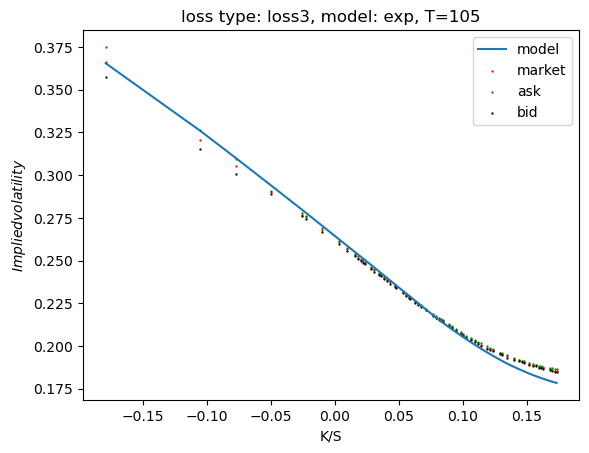

Mean squared error:1.16e-05


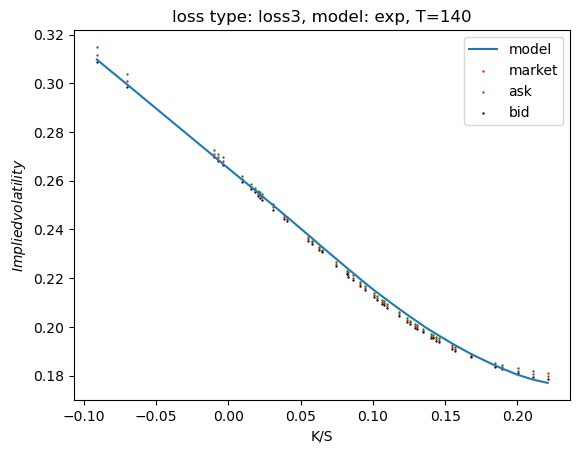

Mean squared error:2.97e-06


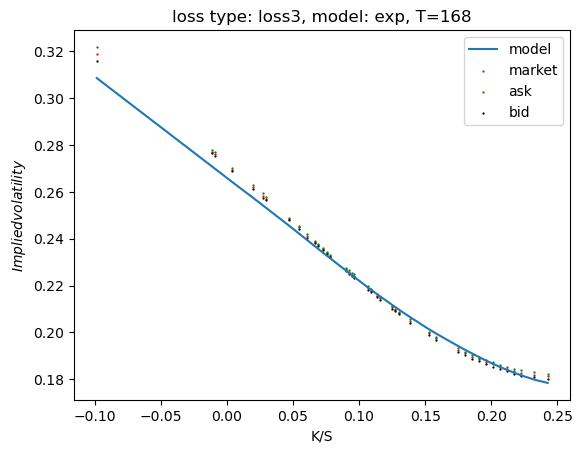

Mean squared error:8.13e-06


In [115]:
print(f"rho={params[0]:.3f}, lam={params[1]:.6f}, eta={params[2]:.3f}, ksi={params[3]:.3f}, a0={params[4]} ")
print(params)
ST = sample_S_exp(T=Ts, rho=params[0], lam=params[1], eta=params[2], ksi=params[3], a0=params[4])[:,:,-1]
T_unique = np.unique(Ts)

call_models = np.array([np.mean(np.maximum(S0s[i]*ST[T_unique.tolist().index(Ts[i])]-Ks[i], 0))  for i in range(len(Ks))])
print(call_models.shape)


for T_view in filter_T:
    T_view = T_view/365

    test_implied_vol(S0=S0s[np.array(Ts)==T_view], T=Ts[np.array(Ts)==T_view], Ks=Ks[np.array(Ts)==T_view], 
                    call_models=call_models[np.array(Ts)==T_view], 
                    vol_markets=np.array(vol_markets)[np.array(Ts)==T_view], 
                    vol_ask = np.array(vol_ask)[np.array(Ts)==T_view],
                    vol_bid = np.array(vol_bid)[np.array(Ts)==T_view],
                    model="exp", loss_type=3)    

In [96]:
vol_markets = [implied_volatility_call_bisection(C=call_markets[i], S=S0s[i], K=Ks[i], T=Ts[i], r=0) for i in range(len(Ks))]
vega = np.array([vega_func(S0s[i], Ks[i], Ts[i], r=0, sigma = vol_markets[i]) + 1e-8 for i in range(len(Ks))])

res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="frac")
params1 = res.x

KeyboardInterrupt: 

[-0.99690491  0.40175046  1.08418908  0.30796271  0.239271  ]
(154,)


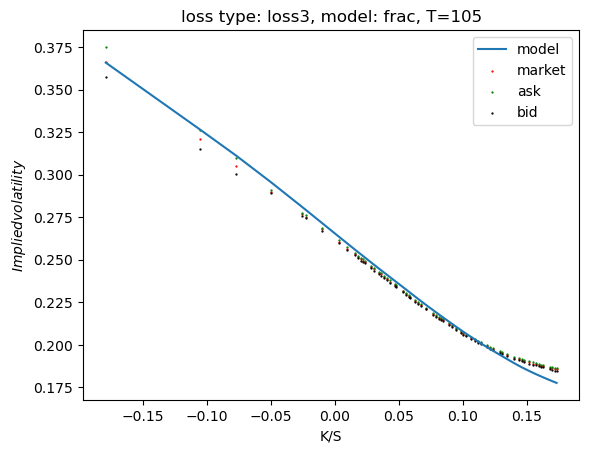

Mean squared error:1.29e-05


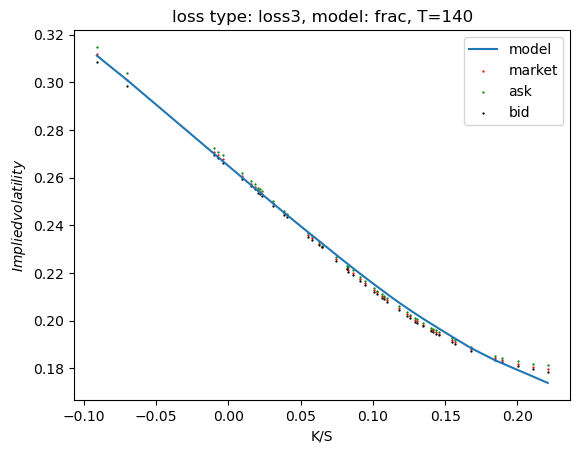

Mean squared error:4.05e-06


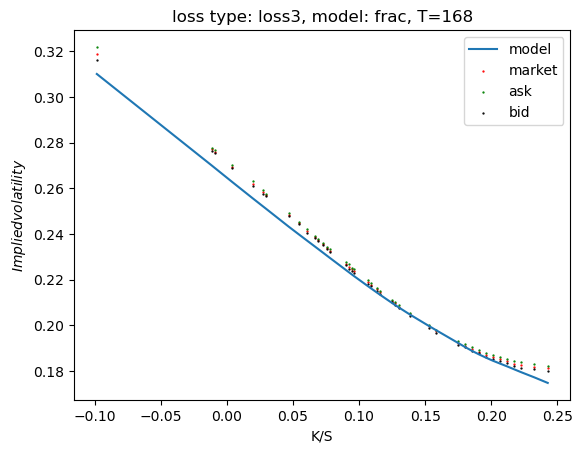

Mean squared error:1.49e-05


In [ ]:
print(params1)
ST = sample_S_frac(T=Ts, rho=params1[0], H=params1[1], c=params1[2], ksi=params1[3], a0=params1[4])[:,:,-1]
T_unique = np.unique(Ts)

call_models = np.array([np.mean(np.maximum(S0s[i]*ST[T_unique.tolist().index(Ts[i])]-Ks[i], 0))  for i in range(len(Ks))])
print(call_models.shape)

for T_view in filter_T:
    T_view = T_view/365
# fig = plt.figure()
# ax = fig.add_subplot(111) 
# ax.scatter(Ks[np.array(Ts)==T_view]/S0s[np.array(Ts)==T_view], np.array(call_markets)[np.array(Ts)==T_view], s=0.4, c="red")
# ax.plot(Ks[np.array(Ts)==T_view]/S0s[np.array(Ts)==T_view], np.array(call_models)[np.array(Ts)==T_view], "-")


# ax.set_xlabel("K/S")
# ax.set_ylabel("Call price")
# ax.set_title(f"loss type: loss3, model: frac, T={int(T_view*365)}")

# plt.show()


    test_implied_vol(S0=S0s[np.array(Ts)==T_view], T=Ts[np.array(Ts)==T_view], Ks=Ks[np.array(Ts)==T_view], 
                    call_models=call_models[np.array(Ts)==T_view], 
                    vol_markets=np.array(vol_markets)[np.array(Ts)==T_view], 
                    vol_ask = np.array(vol_ask)[np.array(Ts)==T_view],
                    vol_bid = np.array(vol_bid)[np.array(Ts)==T_view],
                    model="frac", loss_type=3)    

In [46]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="iso")
params = res.x

KeyboardInterrupt: 

rho=-0.833, lam=4.057, eta=2.508, ksi=0.299, a0=0.42560948854322 
[-0.83260257  1.07735233  0.08417993  0.15850261  0.29865413  0.42560949]
(154,)


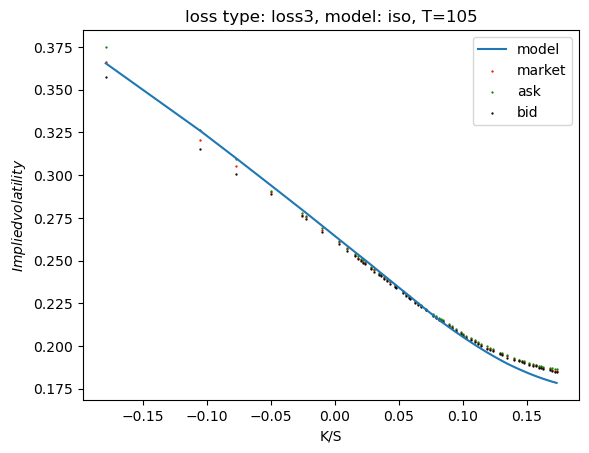

Mean squared error:1.16e-05


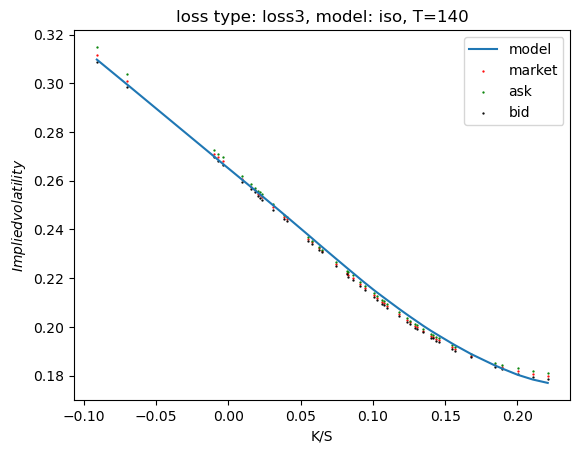

Mean squared error:2.97e-06


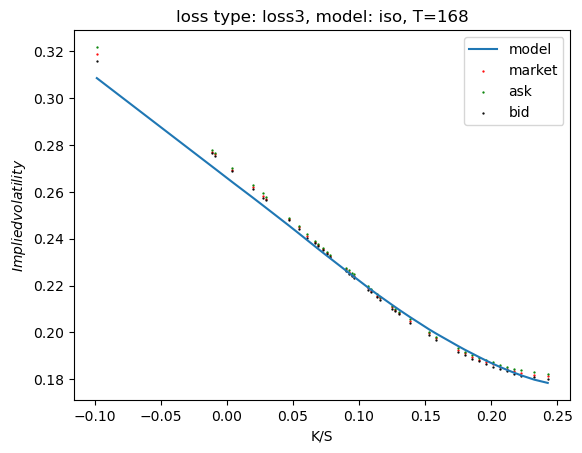

Mean squared error:8.13e-06


In [ ]:
eta = params[1]*params[2]**(params[3]-0.5)
lam = -(params[3]-0.5)/params[2]
print(f"rho={params[0]:.3f}, lam={lam:.3f}, eta={eta:.3f}, ksi={params[4]:.3f}, a0={params[5]} ")
print(params)
ST = sample_S_iso(T=Ts, rho=params[0], v=params[1], epsilon=params[2], H=params[3], ksi=params[4], a0=params[5])[:,:,-1]
T_unique = np.unique(Ts)

call_models = np.array([np.mean(np.maximum(S0s[i]*ST[T_unique.tolist().index(Ts[i])]-Ks[i], 0))  for i in range(len(Ks))])
print(call_models.shape)

for T_view in filter_T:
    T_view = T_view/365
# T_view = filter_T[1]/365

# fig = plt.figure()
# ax = fig.add_subplot(111) 
# ax.scatter(Ks[np.array(Ts)==T_view]/S0s[np.array(Ts)==T_view], np.array(call_markets)[np.array(Ts)==T_view], s=0.4, c="red")
# ax.plot(Ks[np.array(Ts)==T_view]/S0s[np.array(Ts)==T_view], np.array(call_models)[np.array(Ts)==T_view], "-")


# ax.set_xlabel("K/S")
# ax.set_ylabel("Call price")
# ax.set_title(f"loss type: loss3, model: iso, T={int(T_view*365)}")

# plt.show()


    test_implied_vol(S0=S0s[np.array(Ts)==T_view], T=Ts[np.array(Ts)==T_view], Ks=Ks[np.array(Ts)==T_view], 
                    call_models=call_models[np.array(Ts)==T_view], 
                    vol_markets=np.array(vol_markets)[np.array(Ts)==T_view], 
                    vol_ask = np.array(vol_ask)[np.array(Ts)==T_view],
                    vol_bid = np.array(vol_bid)[np.array(Ts)==T_view],
                    model="iso", loss_type=3)    

In [125]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_2, kernel="exp1")
params = res.x

`ftol` termination condition is satisfied.
Function evaluations 17, initial cost 1.0978e+05, final cost 5.6362e+02, first-order optimality 1.78e-01.


rho=-0.839, lam=5.000000, eta=1.586, ksi=0.300, a0=1.2850359029854757 
[-0.83853189  5.          1.58609801  0.29993158  1.2850359 ]
(154,)


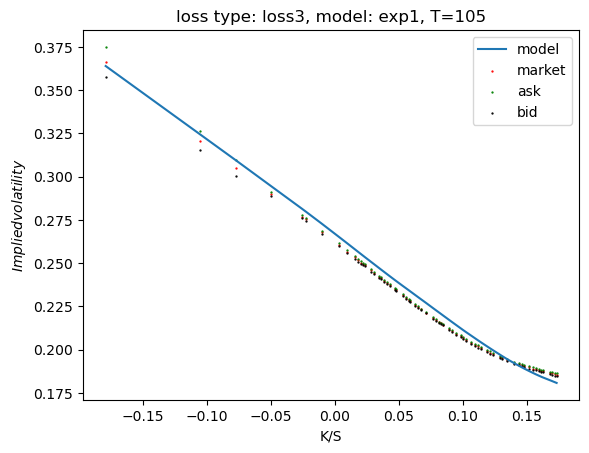

Mean squared error:1.95e-05


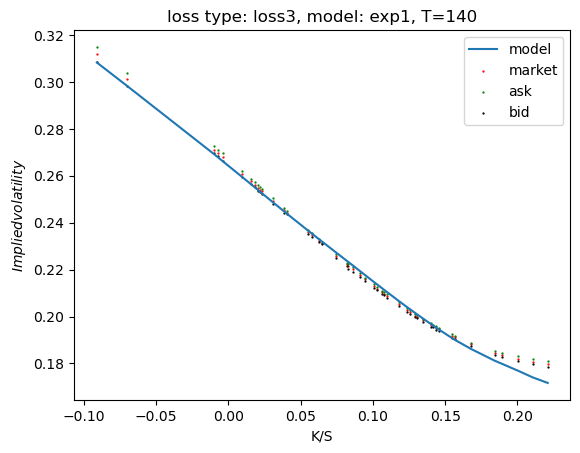

Mean squared error:5.22e-06


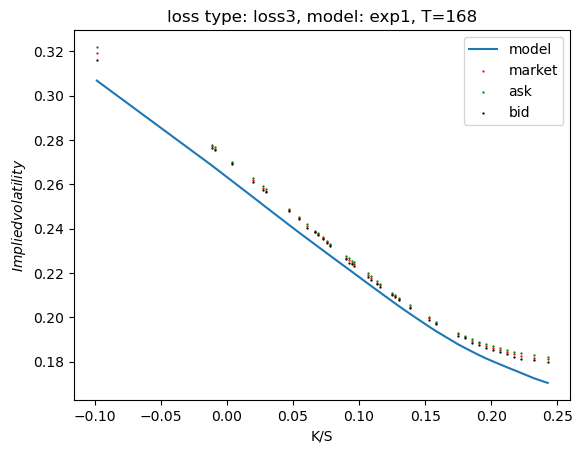

Mean squared error:3.8e-05


In [126]:
print(f"rho={params[0]:.3f}, lam={params[1]:.6f}, eta={params[2]:.3f}, ksi={params[3]:.3f}, a0={params[4]} ")
print(params)
ST = sample_S_exp(T=Ts, rho=params[0], lam=params[1], eta=params[2], ksi=params[3], b=params[4], sig="exp")[:,:,-1]
T_unique = np.unique(Ts)

call_models = np.array([np.mean(np.maximum(S0s[i]*ST[T_unique.tolist().index(Ts[i])]-Ks[i], 0))  for i in range(len(Ks))])
print(call_models.shape)

for T_view in filter_T:
    T_view = T_view/365

    test_implied_vol(S0=S0s[np.array(Ts)==T_view], T=Ts[np.array(Ts)==T_view], Ks=Ks[np.array(Ts)==T_view], 
                 call_models=call_models[np.array(Ts)==T_view], 
                 vol_markets=np.array(vol_markets)[np.array(Ts)==T_view], 
                 vol_ask = np.array(vol_ask)[np.array(Ts)==T_view],
                 vol_bid = np.array(vol_bid)[np.array(Ts)==T_view],
                 model="exp1", loss_type=3)    

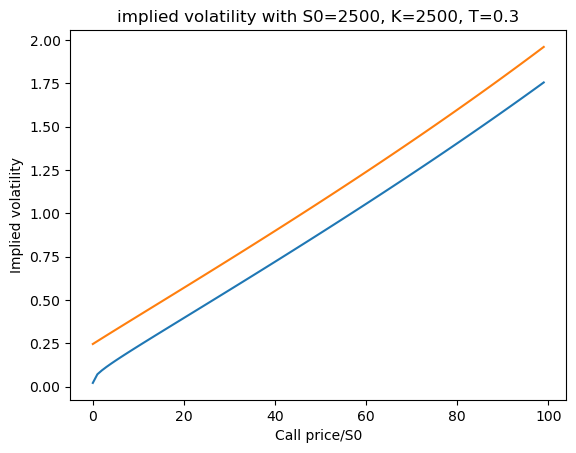

In [145]:
p = np.linspace(0, 1000, 100)
p_bis = p + 100

KKS = np.linspace(2600, 2400, 100)
vol = [implied_volatility_call_newton(C=p[i], S=2500, K=KKS[i], T=1/3, r=0) for i in range(len(p))]
vol_bis = [implied_volatility_call_newton(C=p_bis[i], S=2500, K=KKS[i], T=1/3, r=0) for i in range(len(p))]
plt.xlabel("Call price/S0")
plt.ylabel("Implied volatility")
plt.title("implied volatility with S0=2500, K=2500, T=0.3")
plt.plot(vol)
plt.plot(vol_bis)


In [93]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="ksit")
params = res.x

`ftol` termination condition is satisfied.
Function evaluations 207, initial cost 6.1108e+01, final cost 1.2060e-01, first-order optimality 2.48e-04.


rho=-0.833, lam=0.645527, eta=1.256, alpha0=0.280, alpha1=3.679, beta=0.047, a0=0.518


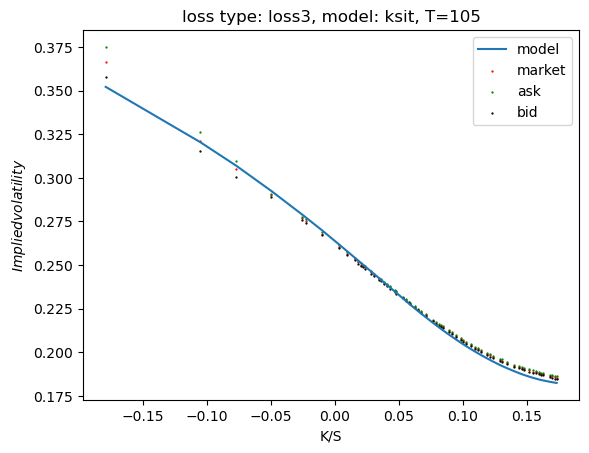

Mean squared error:7.72e-06


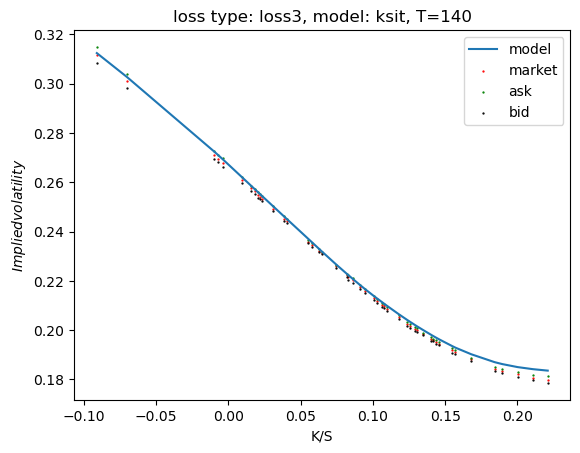

Mean squared error:2.42e-06


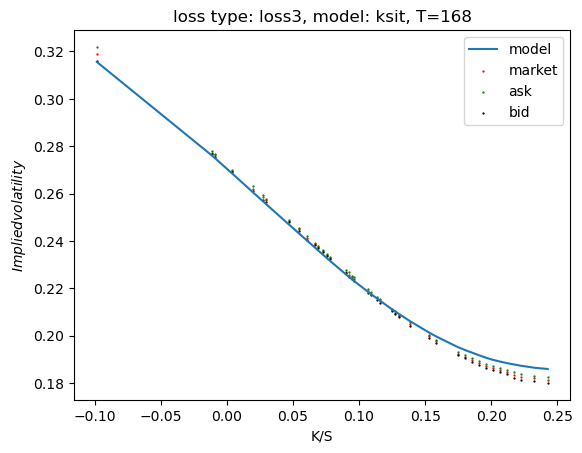

Mean squared error:5.4e-06


In [101]:
print(f"rho={params[0]:.3f}, lam={params[1]:.6f}, eta={params[2]:.3f}, alpha0={params[3]:.3f}, alpha1={params[4]:.3f}, beta={params[5]:.3f}, a0={params[6]:.3f}")
ST = sample_S_exp(T=Ts, rho=params[0], lam=params[1], eta=params[2], alpha0=params[3], alpha1=params[4], beta=params[5], a0=params[6], sig="ksit")[:,:,-1]
T_unique = np.unique(Ts)
call_models = np.array([np.mean(np.maximum(S0s[i]*ST[T_unique.tolist().index(Ts[i])]-Ks[i], 0))  for i in range(len(Ks))])

for T_view in filter_T:
    T_view = T_view/365

    test_implied_vol(S0=S0s[np.array(Ts)==T_view], T=Ts[np.array(Ts)==T_view], Ks=Ks[np.array(Ts)==T_view], 
                 call_models=call_models[np.array(Ts)==T_view], 
                 vol_markets=np.array(vol_markets)[np.array(Ts)==T_view], 
                 vol_ask = np.array(vol_ask)[np.array(Ts)==T_view],
                 vol_bid = np.array(vol_bid)[np.array(Ts)==T_view],
                 model="ksit", loss_type=3)    

### Calibration with larger range of T

In [55]:
# Read data
data = pd.read_csv('../data/UnderlyingOptionsEODCalcs_2022-09-02.csv')

# Remove all data not traded in reality
data = data[data["trade_volume"]>0]

# Rename some columns according to convention
data.rename(columns={'strike': 'K','implied_underlying_price_1545':'S0', "implied_volatility_1545":"implied_volatility", "vega_1545":"vega"}, inplace=True)

# We only process data for calls here
data = data[data['option_type']=='C']
data = data[data["root"]=="SPX"]
# Calculate the time difference based on the quote date and expiration and convert to days
data['T'] = (data["expiration"].map(lambda x: pd.Timestamp(x)) - data["quote_date"].map(lambda x: pd.Timestamp(x))).map(lambda x: int(x.days))

# We use the average of bid and ask for the actual market price
data['call_markets'] = 0.5 * (data['bid_1545']+data['ask_1545'])

print(data["T"].value_counts().sort_index())
# filter_T = [14, 49, 105, 196, 378]
# filter_KS = {filter_T[0]:0.08, filter_T[1]:0.15, filter_T[2]:0.2, filter_T[3]:0.3, filter_T[4]:0.5}
filter_T= [14, 49, 105, 140]
filter_KS = {filter_T[0]:0.05, filter_T[1]:0.1, filter_T[2]:0.15, filter_T[3]:0.2}
data = data[(data['T'].isin(filter_T))]

data["KS"] = data["T"].map(lambda x: filter_KS[x])
data = data[np.abs((data["K"]-data["S0"])/data["S0"])<data["KS"]]

S0s = data['S0'].to_numpy()
Ks = data['K'].to_numpy()
Ts = data['T'].to_numpy()/365 # If we don't divide T by 365, there will be overflow for calculations of covariance matrix

call_markets = data['call_markets'].to_numpy()
vega = data["vega"].to_numpy()
vol_markets = data["implied_volatility"].to_numpy()

assert len(S0s)==len(Ks)

print("All maturities:")
print(data["T"].value_counts().sort_index())
print("Total points:", len(Ks))

call_ask = data['ask_1545'].to_numpy()
call_bid = data['bid_1545'].to_numpy()

vol_markets = [implied_volatility_call_bisection(C=call_markets[i], S=S0s[i], K=Ks[i], T=Ts[i], r=0) for i in range(len(Ks))]
vol_ask = [implied_volatility_call_bisection(C=call_ask[i], S=S0s[i], K=Ks[i], T=Ts[i], r=0) for i in range(len(Ks))]
vol_bid = [implied_volatility_call_bisection(C=call_bid[i], S=S0s[i], K=Ks[i], T=Ts[i], r=0) for i in range(len(Ks))]
vega = np.array([vega_func(S0s[i], Ks[i], Ts[i], r=0, sigma = vol_markets[i]) + 1e-8 for i in range(len(Ks))])


14      134
49      173
77       69
105      81
140      57
168      48
196      41
231      14
259      17
287      31
322       3
350      10
378      19
469      29
658       7
840       2
1568      2
1932      2
Name: T, dtype: int64
All maturities:
14     62
49     96
105    51
140    42
Name: T, dtype: int64
Total points: 251


In [56]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="exp")
params1 = res.x

`ftol` termination condition is satisfied.
Function evaluations 32, initial cost 2.3929e+02, final cost 3.6378e+00, first-order optimality 1.92e-03.


rho=-0.739, lam=4.999994, eta=3.740, ksi=0.285, a0=0.14255689727819257 
[-0.73867379  4.99999446  3.7403426   0.28528403  0.1425569 ]
(251,)


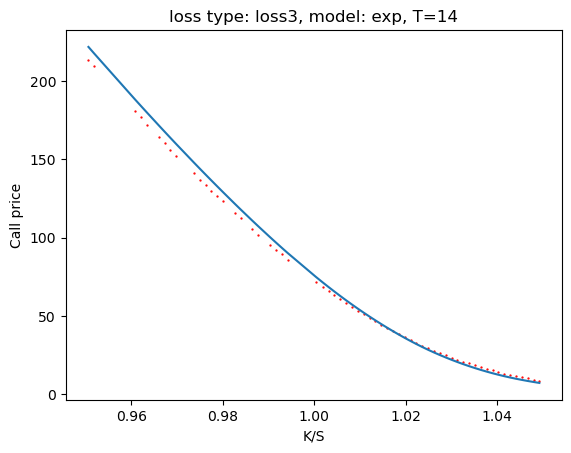

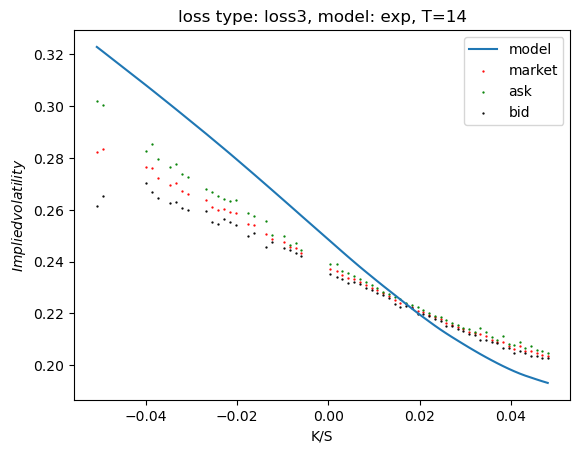

Mean squared error:0.000278


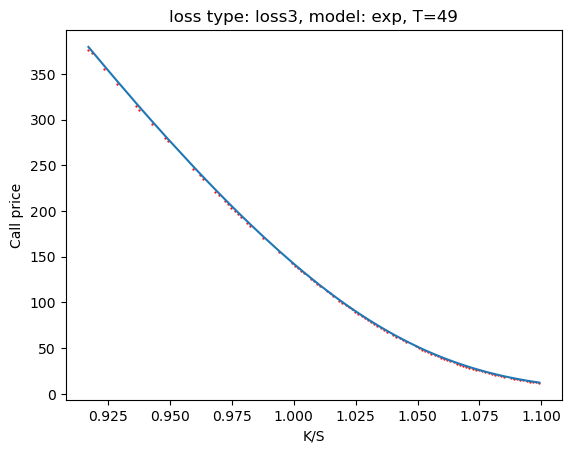

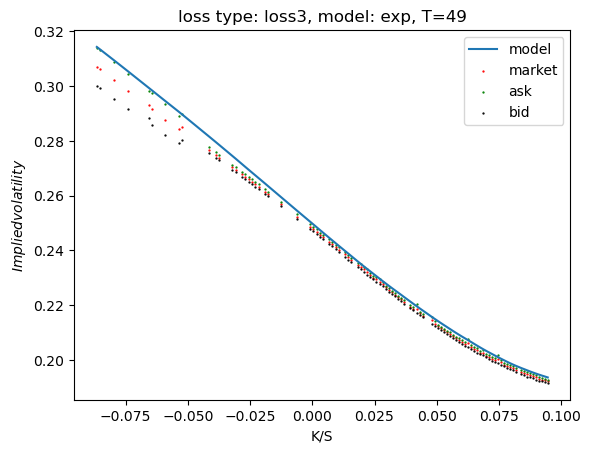

Mean squared error:8.02e-06


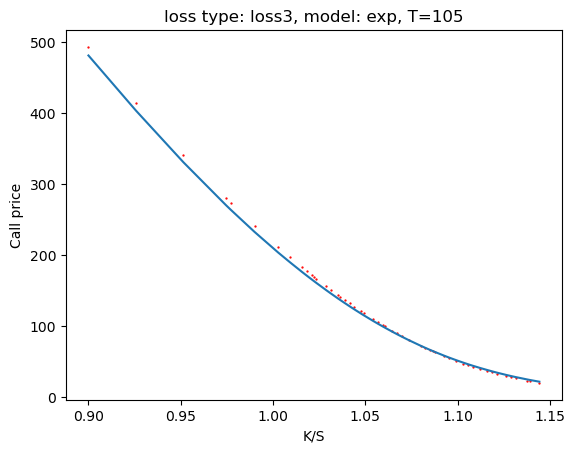

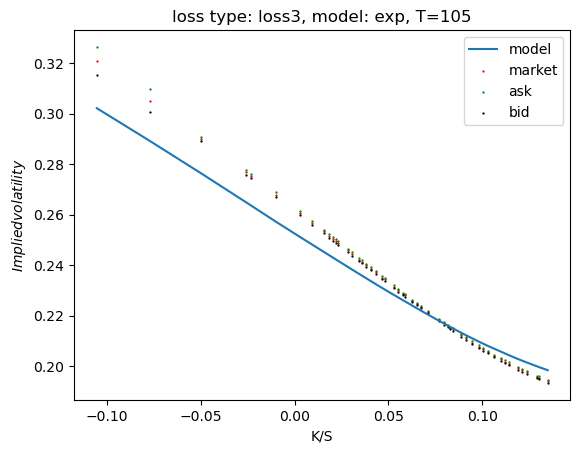

Mean squared error:4.05e-05


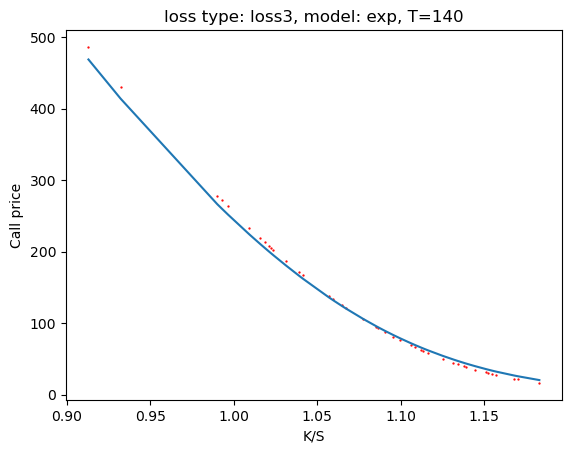

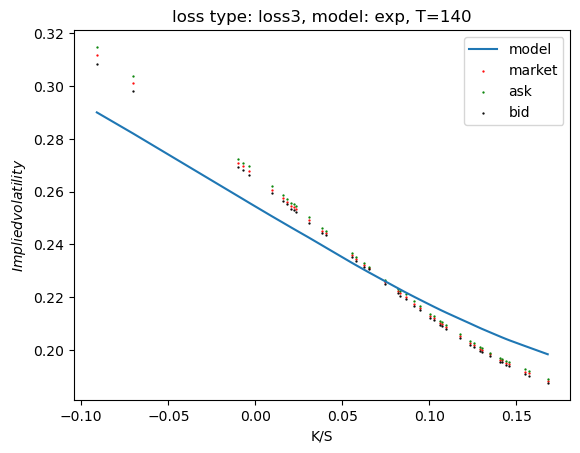

Mean squared error:7.09e-05


In [57]:
print(f"rho={params1[0]:.3f}, lam={params1[1]:.6f}, eta={params1[2]:.3f}, ksi={params1[3]:.3f}, a0={params1[4]} ")
print(params1)
ST = sample_S_exp(T=Ts, rho=params1[0], lam=params1[1], eta=params1[2], ksi=params1[3], a0=params1[4])[:,:,-1]
T_unique = np.unique(Ts)

call_models = np.array([np.mean(np.maximum(S0s[i]*ST[T_unique.tolist().index(Ts[i])]-Ks[i], 0))  for i in range(len(Ks))])
print(call_models.shape)


for T_view in filter_T:
    T_view = T_view/365
    fig = plt.figure()
    ax = fig.add_subplot(111) 
    ax.scatter(Ks[np.array(Ts)==T_view]/S0s[np.array(Ts)==T_view], np.array(call_markets)[np.array(Ts)==T_view], s=0.4, c="red")
    ax.plot(Ks[np.array(Ts)==T_view]/S0s[np.array(Ts)==T_view], np.array(call_models)[np.array(Ts)==T_view], "-")


    ax.set_xlabel("K/S")
    ax.set_ylabel("Call price")
    ax.set_title(f"loss type: loss3, model: exp, T={T_view*365:.0f}")

    plt.show()

    test_implied_vol(S0=S0s[np.array(Ts)==T_view], T=Ts[np.array(Ts)==T_view], Ks=Ks[np.array(Ts)==T_view], 
                    call_models=call_models[np.array(Ts)==T_view], 
                    vol_markets=np.array(vol_markets)[np.array(Ts)==T_view], 
                    vol_ask = np.array(vol_ask)[np.array(Ts)==T_view],
                    vol_bid = np.array(vol_bid)[np.array(Ts)==T_view],
                    model="exp", loss_type=3)    

In [153]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_2, kernel="exp")
params = res.x

`ftol` termination condition is satisfied.
Function evaluations 155, initial cost 1.6344e+05, final cost 1.4246e+03, first-order optimality 4.00e-02.


rho=-0.821, lam=4.999789, eta=3.997, ksi=0.291, a0=0.13738077026830012 
[-0.82050186  4.99978929  3.99655244  0.29065227  0.13738077]
(273,)


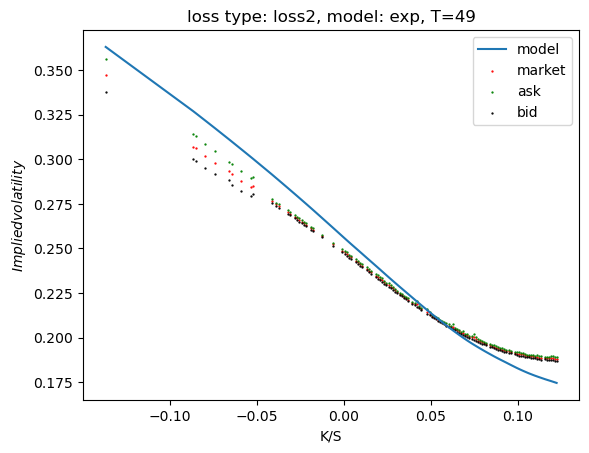

Mean squared error:8.03e-05


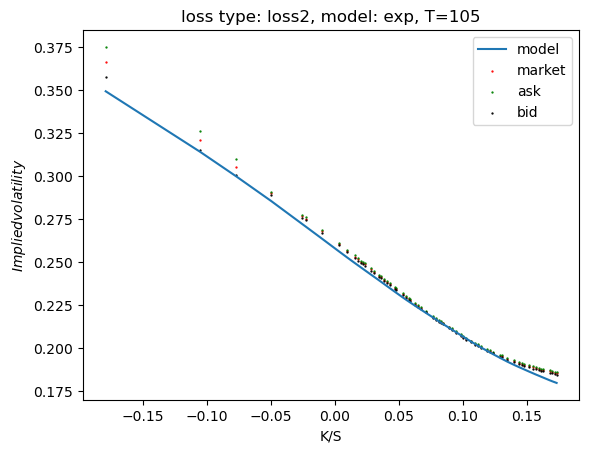

Mean squared error:1.28e-05


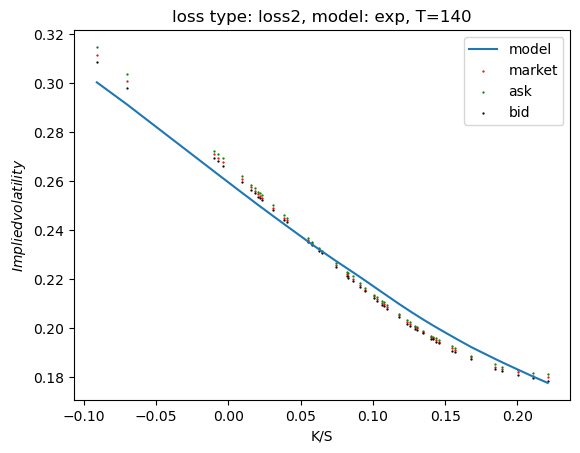

Mean squared error:2.15e-05


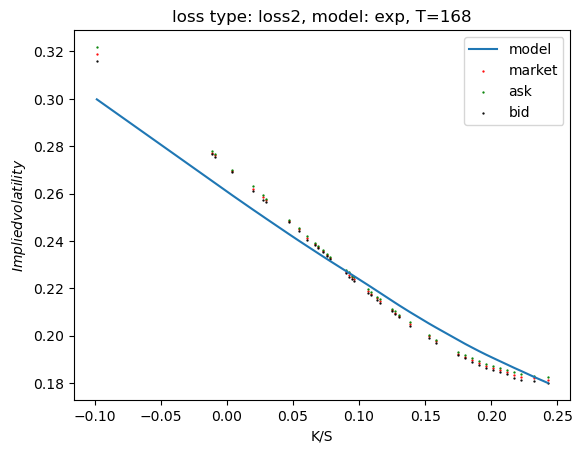

Mean squared error:3.47e-05


In [154]:
print(f"rho={params[0]:.3f}, lam={params[1]:.6f}, eta={params[2]:.3f}, ksi={params[3]:.3f}, a0={params[4]} ")
print(params)
ST = sample_S_exp(T=Ts, rho=params[0], lam=params[1], eta=params[2], ksi=params[3], a0=params[4])[:,:,-1]
T_unique = np.unique(Ts)

call_models = np.array([np.mean(np.maximum(S0s[i]*ST[T_unique.tolist().index(Ts[i])]-Ks[i], 0))  for i in range(len(Ks))])
print(call_models.shape)


for T_view in filter_T:
    T_view = T_view/365

    test_implied_vol(S0=S0s[np.array(Ts)==T_view], T=Ts[np.array(Ts)==T_view], Ks=Ks[np.array(Ts)==T_view], 
                    call_models=call_models[np.array(Ts)==T_view], 
                    vol_markets=np.array(vol_markets)[np.array(Ts)==T_view], 
                    vol_ask = np.array(vol_ask)[np.array(Ts)==T_view],
                    vol_bid = np.array(vol_bid)[np.array(Ts)==T_view],
                    model="exp", loss_type=2)    

In [58]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="ksit")
params = res.x

`ftol` termination condition is satisfied.
Function evaluations 26, initial cost 2.7788e+02, final cost 2.0756e-01, first-order optimality 4.75e-05.


rho=-0.810, lam=0.313561, eta=1.098, alpha0=0.236, alpha1=0.349, beta=2.622, a0=0.486


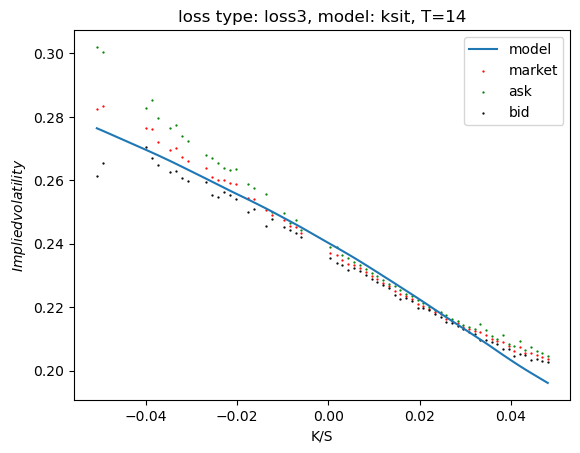

Mean squared error:1.19e-05


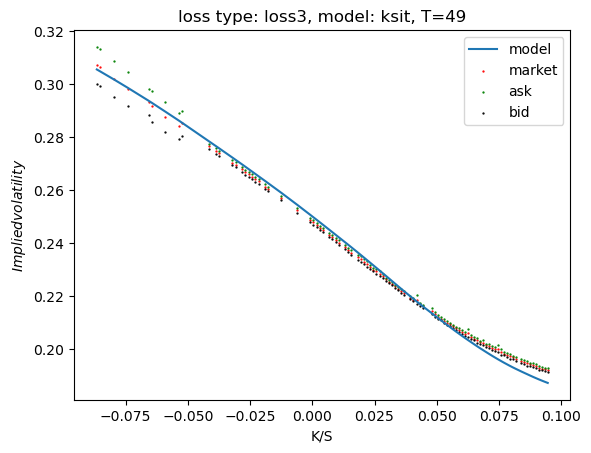

Mean squared error:5.28e-06


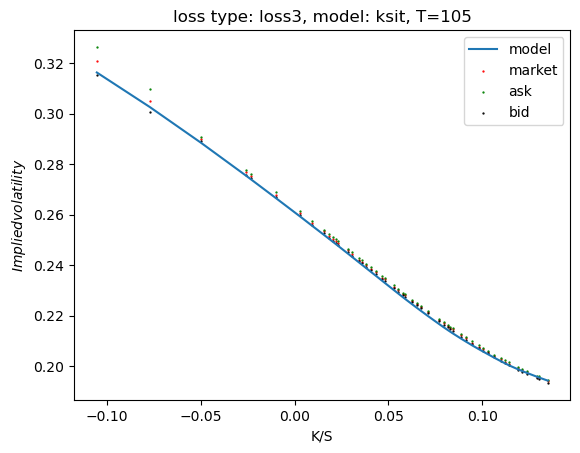

Mean squared error:1.88e-06


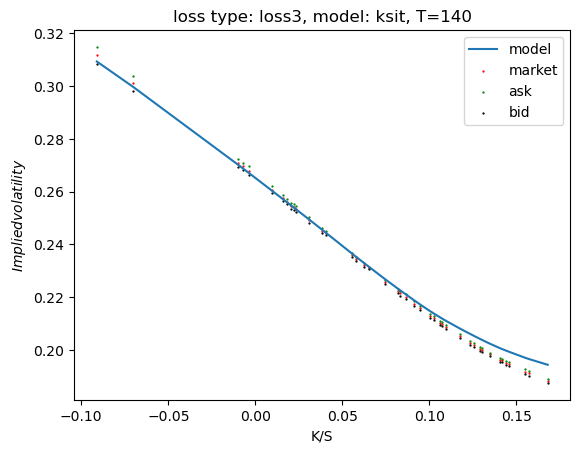

Mean squared error:6.92e-06


In [59]:
print(f"rho={params[0]:.3f}, lam={params[1]:.6f}, eta={params[2]:.3f}, alpha0={params[3]:.3f}, alpha1={params[4]:.3f}, beta={params[5]:.3f}, a0={params[6]:.3f}")
ST = sample_S_exp(T=Ts, rho=params[0], lam=params[1], eta=params[2], alpha0=params[3], alpha1=params[4], beta=params[5], a0=params[6], sig="ksit")[:,:,-1]
T_unique = np.unique(Ts)
call_models = np.array([np.mean(np.maximum(S0s[i]*ST[T_unique.tolist().index(Ts[i])]-Ks[i], 0))  for i in range(len(Ks))])

for T_view in filter_T:
    T_view = T_view/365

    test_implied_vol(S0=S0s[np.array(Ts)==T_view], T=Ts[np.array(Ts)==T_view], Ks=Ks[np.array(Ts)==T_view], 
                 call_models=call_models[np.array(Ts)==T_view], 
                 vol_markets=np.array(vol_markets)[np.array(Ts)==T_view], 
                 vol_ask = np.array(vol_ask)[np.array(Ts)==T_view],
                 vol_bid = np.array(vol_bid)[np.array(Ts)==T_view],
                 model="ksit", loss_type=3)    

In [60]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="ksit_frac")
params = res.x

`ftol` termination condition is satisfied.
Function evaluations 33, initial cost 2.2833e+02, final cost 2.0791e-01, first-order optimality 4.45e-04.


rho=-0.812, H=0.496634, c=1.074, alpha0=0.236, alpha1=0.351, beta=2.595, a0=0.488


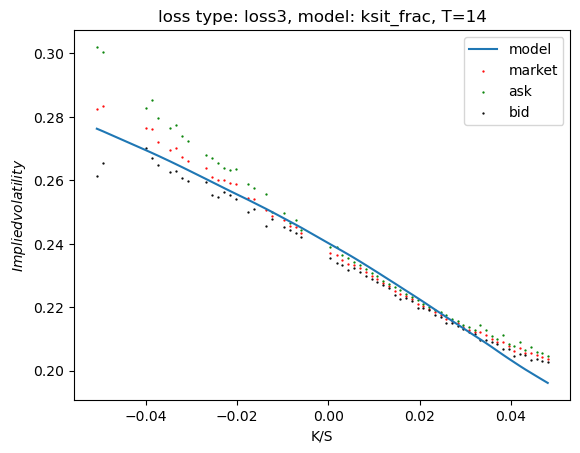

Mean squared error:1.19e-05


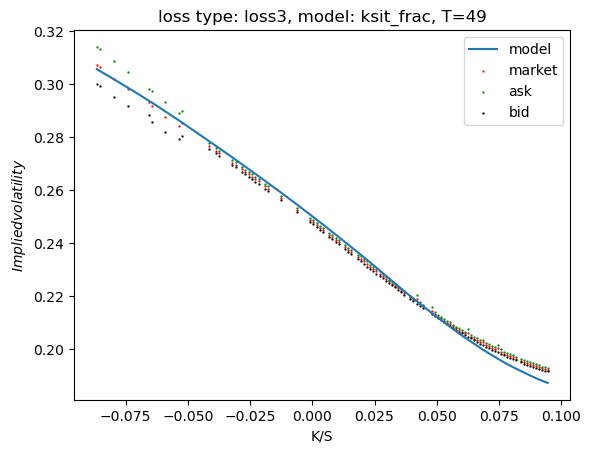

Mean squared error:5.31e-06


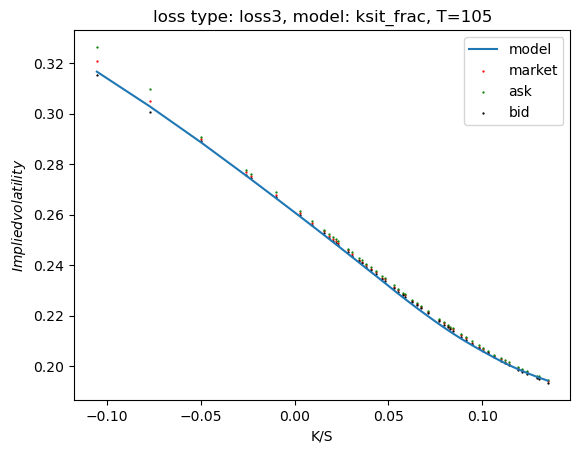

Mean squared error:1.83e-06


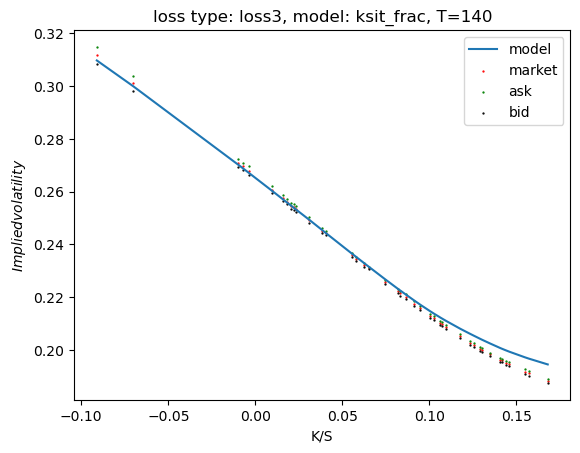

Mean squared error:7.08e-06


In [61]:
print(f"rho={params[0]:.3f}, H={params[1]:.6f}, c={params[2]:.3f}, alpha0={params[3]:.3f}, alpha1={params[4]:.3f}, beta={params[5]:.3f}, a0={params[6]:.3f}")
ST = sample_S_frac(T=Ts, rho=params[0], H=params[1], c=params[2], alpha0=params[3], alpha1=params[4], beta=params[5], a0=params[6], sig="ksit")[:,:,-1]
T_unique = np.unique(Ts)
call_models = np.array([np.mean(np.maximum(S0s[i]*ST[T_unique.tolist().index(Ts[i])]-Ks[i], 0))  for i in range(len(Ks))])

for T_view in filter_T:
    T_view = T_view/365

    test_implied_vol(S0=S0s[np.array(Ts)==T_view], T=Ts[np.array(Ts)==T_view], Ks=Ks[np.array(Ts)==T_view], 
                 call_models=call_models[np.array(Ts)==T_view], 
                 vol_markets=np.array(vol_markets)[np.array(Ts)==T_view], 
                 vol_ask = np.array(vol_ask)[np.array(Ts)==T_view],
                 vol_bid = np.array(vol_bid)[np.array(Ts)==T_view],
                 model="ksit_frac", loss_type=3)    

### Less points

In [68]:
# Read data
data = pd.read_csv('../data/UnderlyingOptionsEODCalcs_2022-09-02.csv')

# Remove all data not traded in reality
data = data[data["trade_volume"]>0]

# Rename some columns according to convention
data.rename(columns={'strike': 'K','implied_underlying_price_1545':'S0', "implied_volatility_1545":"implied_volatility", "vega_1545":"vega"}, inplace=True)

# We only process data for calls here
data = data[data['option_type']=='C']
data = data[data["root"]=="SPX"]
# Calculate the time difference based on the quote date and expiration and convert to days
data['T'] = (data["expiration"].map(lambda x: pd.Timestamp(x)) - data["quote_date"].map(lambda x: pd.Timestamp(x))).map(lambda x: int(x.days))

# We use the average of bid and ask for the actual market price
data['call_markets'] = 0.5 * (data['bid_1545']+data['ask_1545'])

print(data["T"].value_counts().sort_index())
# filter_T = [14, 49, 105, 196, 378]
# filter_KS = {filter_T[0]:0.08, filter_T[1]:0.15, filter_T[2]:0.2, filter_T[3]:0.3, filter_T[4]:0.5}
filter_T= [49, 105, 140]
filter_KS = {filter_T[0]:0.1, filter_T[1]:0.15, filter_T[2]:0.2}
data = data[(data['T'].isin(filter_T))]

data["KS"] = data["T"].map(lambda x: filter_KS[x])
data = data[np.abs((data["K"]-data["S0"])/data["S0"])<data["KS"]]

# sample rate
data = data[::7]

S0s = data['S0'].to_numpy()
Ks = data['K'].to_numpy()
Ts = data['T'].to_numpy()/365 # If we don't divide T by 365, there will be overflow for calculations of covariance matrix

call_markets = data['call_markets'].to_numpy()
vega = data["vega"].to_numpy()
vol_markets = data["implied_volatility"].to_numpy()

assert len(S0s)==len(Ks)

print("All maturities:")
print(data["T"].value_counts().sort_index())
print("Total points:", len(Ks))

call_ask = data['ask_1545'].to_numpy()
call_bid = data['bid_1545'].to_numpy()

vol_markets = [implied_volatility_call_bisection(C=call_markets[i], S=S0s[i], K=Ks[i], T=Ts[i], r=0) for i in range(len(Ks))]
vol_ask = [implied_volatility_call_bisection(C=call_ask[i], S=S0s[i], K=Ks[i], T=Ts[i], r=0) for i in range(len(Ks))]
vol_bid = [implied_volatility_call_bisection(C=call_bid[i], S=S0s[i], K=Ks[i], T=Ts[i], r=0) for i in range(len(Ks))]
vega = np.array([vega_func(S0s[i], Ks[i], Ts[i], r=0, sigma = vol_markets[i]) + 1e-8 for i in range(len(Ks))])


14      134
49      173
77       69
105      81
140      57
168      48
196      41
231      14
259      17
287      31
322       3
350      10
378      19
469      29
658       7
840       2
1568      2
1932      2
Name: T, dtype: int64
All maturities:
49     14
105     7
140     6
Name: T, dtype: int64
Total points: 27


In [47]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="exp")
params1 = res.x

`ftol` termination condition is satisfied.
Function evaluations 20, initial cost 2.9965e+01, final cost 2.4945e-01, first-order optimality 1.39e-06.


rho=-0.812, lam=5.000000, eta=0.000, ksi=0.293, a0=2.095014490680803e-24 
[-8.12339544e-01  5.00000000e+00  4.41489540e-04  2.92587456e-01
  2.09501449e-24]
(27,)


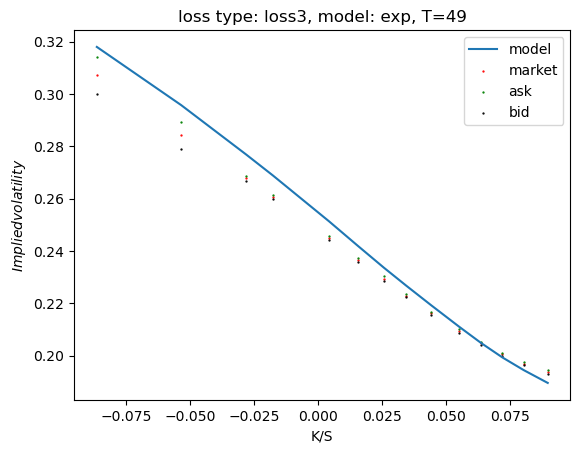

Mean squared error:3.86e-05


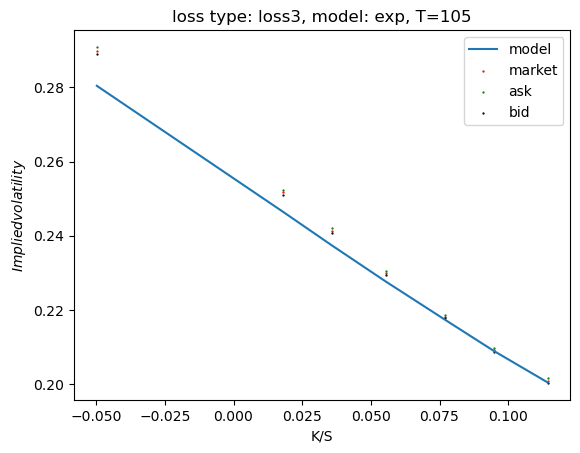

Mean squared error:2.01e-05


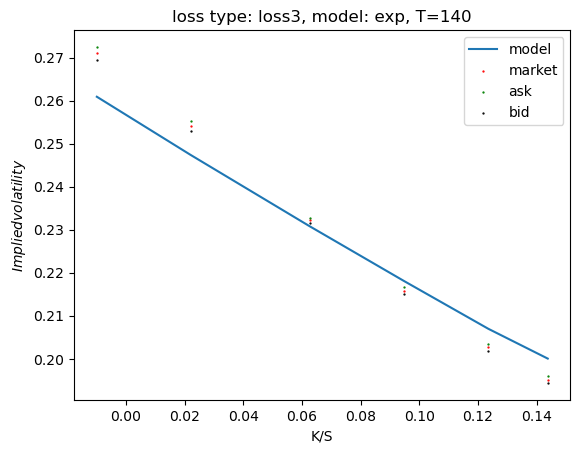

Mean squared error:3.27e-05


In [48]:
print(f"rho={params1[0]:.3f}, lam={params1[1]:.6f}, eta={params1[2]:.3f}, ksi={params1[3]:.3f}, a0={params1[4]} ")
print(params1)
ST = sample_S_exp(T=Ts, rho=params1[0], lam=params1[1], eta=params1[2], ksi=params1[3], a0=params1[4])[:,:,-1]
T_unique = np.unique(Ts)

call_models = np.array([np.mean(np.maximum(S0s[i]*ST[T_unique.tolist().index(Ts[i])]-Ks[i], 0))  for i in range(len(Ks))])
print(call_models.shape)


for T_view in filter_T:
    T_view = T_view/365

    test_implied_vol(S0=S0s[np.array(Ts)==T_view], T=Ts[np.array(Ts)==T_view], Ks=Ks[np.array(Ts)==T_view], 
                    call_models=call_models[np.array(Ts)==T_view], 
                    vol_markets=np.array(vol_markets)[np.array(Ts)==T_view], 
                    vol_ask = np.array(vol_ask)[np.array(Ts)==T_view],
                    vol_bid = np.array(vol_bid)[np.array(Ts)==T_view],
                    model="exp", loss_type=3)    

In [69]:
res = calibration(Ks=Ks, y=call_markets, S0=S0s, T=Ts, loss=loss_3, kernel="ksit")
params = res.x

`ftol` termination condition is satisfied.
Function evaluations 45, initial cost 2.4630e+01, final cost 4.2097e-03, first-order optimality 6.70e-05.


rho=-0.840, lam=1.759007, eta=0.982, alpha0=0.000, alpha1=0.308, beta=6.457, a0=0.532


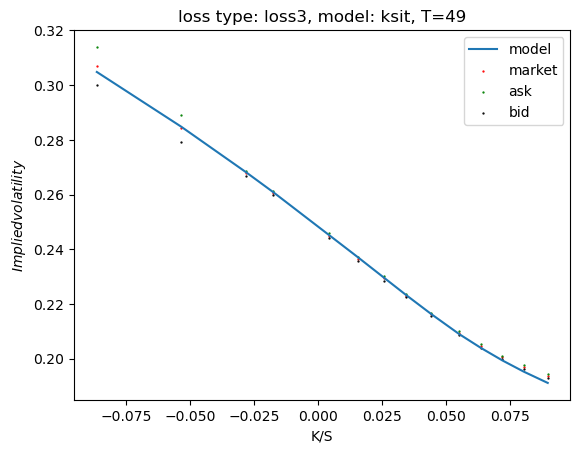

Mean squared error:1.25e-06


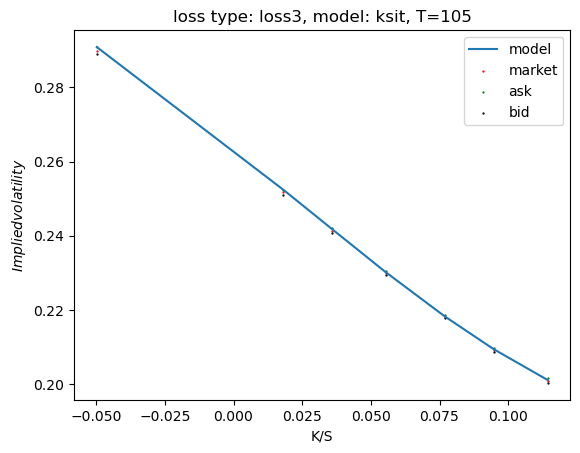

Mean squared error:2.46e-07


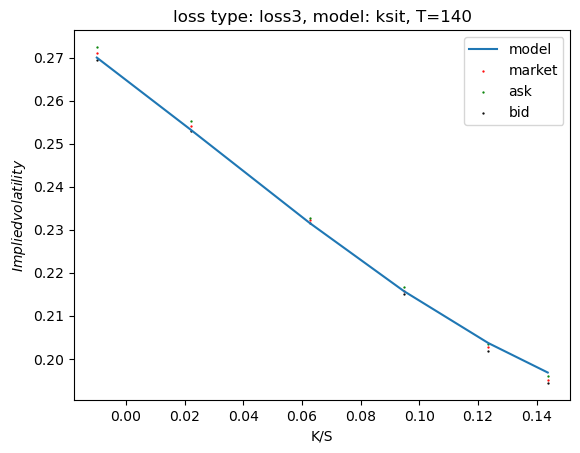

Mean squared error:9.57e-07


In [70]:
print(f"rho={params[0]:.3f}, lam={params[1]:.6f}, eta={params[2]:.3f}, alpha0={params[3]:.3f}, alpha1={params[4]:.3f}, beta={params[5]:.3f}, a0={params[6]:.3f}")
ST = sample_S_exp(T=Ts, rho=params[0], lam=params[1], eta=params[2], alpha0=params[3], alpha1=params[4], beta=params[5], a0=params[6], sig="ksit")[:,:,-1]
T_unique = np.unique(Ts)
call_models = np.array([np.mean(np.maximum(S0s[i]*ST[T_unique.tolist().index(Ts[i])]-Ks[i], 0))  for i in range(len(Ks))])

for T_view in filter_T:
    T_view = T_view/365

    test_implied_vol(S0=S0s[np.array(Ts)==T_view], T=Ts[np.array(Ts)==T_view], Ks=Ks[np.array(Ts)==T_view], 
                 call_models=call_models[np.array(Ts)==T_view], 
                 vol_markets=np.array(vol_markets)[np.array(Ts)==T_view], 
                 vol_ask = np.array(vol_ask)[np.array(Ts)==T_view],
                 vol_bid = np.array(vol_bid)[np.array(Ts)==T_view],
                 model="ksit", loss_type=3)    

$\xi(t)=\alpha _0 e^{-\beta ^2 t} + \alpha _1 (1- e^{-\beta ^2 t})$

$P(X)=a_0 + a_1 X$